# 🏦 Credit Risk Prediction Model
## Final Task — ID/X Partners × Rakamin Academy

---

**Objective:**  
Membangun model machine learning untuk memprediksi risiko kredit peminjam (*credit risk*) berdasarkan dataset pinjaman historis, sehingga perusahaan multifinance dapat mengoptimalkan keputusan pemberian kredit dan meminimalkan potensi kerugian finansial.

**Pipeline End-to-End:**

```
Data Understanding → EDA → Data Preparation → Modelling → Evaluation → Recommendation
```

**Algoritma yang digunakan:**
1. Logistic Regression *(model wajib — baseline)*
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost

**Dataset:** Loan Dataset 2007–2014 | **466.285 baris × 75 kolom**  
**Tools:** Python · Scikit-learn · XGBoost · Imbalanced-learn · Pandas · Matplotlib · Seaborn

---
## 📦 0. Import Libraries

In [81]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DejaVu Sans'
PALETTE = 'Set2'

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold
)

# Imbalance Handling
from imblearn.under_sampling import RandomUnderSampler

# Models 
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score
)

print(f'   Pandas    : {pd.__version__}')
print(f'   Numpy     : {np.__version__}')
print(f'   Sklearn   : {__import__("sklearn").__version__}')
print(f'   XGBoost   : {xgb.__version__}')

   Pandas    : 2.2.3
   Numpy     : 2.2.3
   Sklearn   : 1.6.1
   XGBoost   : 3.2.0


---
## 📂 1. Data Understanding

> Tahap pertama adalah memahami struktur, tipe data, distribusi awal, dan kualitas dataset sebelum melakukan analisis lebih lanjut. Pemahaman yang baik pada tahap ini akan memandu seluruh proses berikutnya.

### 1.1 Load Dataset

In [82]:
df = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)

print('  RINGKASAN DATASET')
print(f'  Jumlah Baris  : {df.shape[0]:>10,}')
print(f'  Jumlah Kolom  : {df.shape[1]:>10}')
df.head(5)

  RINGKASAN DATASET
  Jumlah Baris  :    466,285
  Jumlah Kolom  :         75


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Struktur Data & Tipe Kolom

In [83]:
# Ringkasan tipe data
dtype_summary = df.dtypes.value_counts().reset_index()
dtype_summary.columns = ['Tipe Data', 'Jumlah Kolom']

print(' Komposisi Tipe Data ')
print(dtype_summary.to_string(index=False))

print('\nInfo Dataset (ringkas)')
df.info(verbose=False, show_counts=True)

 Komposisi Tipe Data 
Tipe Data  Jumlah Kolom
  float64            46
   object            22
    int64             7

Info Dataset (ringkas)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Columns: 75 entries, Unnamed: 0 to inq_last_12m
dtypes: float64(46), int64(7), object(22)
memory usage: 266.8+ MB


### 1.3 Statistik Deskriptif

In [84]:
desc = df.describe().T
desc.style.background_gradient(cmap='Blues', subset=['mean', 'std', '50%'])

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.000000,233142.000000,134605.029472,0.000000,116571.000000,233142.000000,349713.000000,466284.000000
id,466285.000000,13079729.906182,10893711.624551,54734.000000,3639987.000000,10107897.000000,20731209.000000,38098114.000000
member_id,466285.000000,14597660.622827,11682367.441450,70473.000000,4379705.000000,11941075.000000,23001541.000000,40860827.000000
loan_amnt,466285.000000,14317.277577,8286.509164,500.000000,8000.000000,12000.000000,20000.000000,35000.000000
funded_amnt,466285.000000,14291.801044,8274.371300,500.000000,8000.000000,12000.000000,20000.000000,35000.000000
funded_amnt_inv,466285.000000,14222.329888,8297.637788,0.000000,8000.000000,12000.000000,19950.000000,35000.000000
int_rate,466285.000000,13.829236,4.357587,5.420000,10.990000,13.660000,16.490000,26.060000
installment,466285.000000,432.061201,243.485550,15.670000,256.690000,379.890000,566.580000,1409.990000
annual_inc,466281.000000,73277.381470,54963.568654,1896.000000,45000.000000,63000.000000,88960.000000,7500000.000000
dti,466285.000000,17.218758,7.851121,0.000000,11.360000,16.870000,22.780000,39.990000


### 1.4 Identifikasi Kolom Target — `loan_status`

Kolom `loan_status` adalah kunci untuk membuat label target `credit_risk`. Perlu dipahami makna setiap nilai di kolom ini.

In [85]:
print('Distribusi nilai loan_status:')
print('-' * 55)
vc_ls = df['loan_status'].value_counts()
for status, count in vc_ls.items():
    pct = count / len(df) * 100
    print(f'  {status:<50} {count:>7,}  ({pct:.2f}%)')
print('-' * 55)
print(f'  Total : {len(df):>56,}')

Distribusi nilai loan_status:
-------------------------------------------------------
  Current                                            224,226  (48.09%)
  Fully Paid                                         184,739  (39.62%)
  Charged Off                                         42,475  (9.11%)
  Late (31-120 days)                                   6,900  (1.48%)
  In Grace Period                                      3,146  (0.67%)
  Does not meet the credit policy. Status:Fully Paid   1,988  (0.43%)
  Late (16-30 days)                                    1,218  (0.26%)
  Default                                                832  (0.18%)
  Does not meet the credit policy. Status:Charged Off     761  (0.16%)
-------------------------------------------------------
  Total :                                                  466,285


### 1.5 Pemeriksaan Kualitas Data

**A. Missing Values**

Kolom dengan missing value : 40 dari 75 kolom



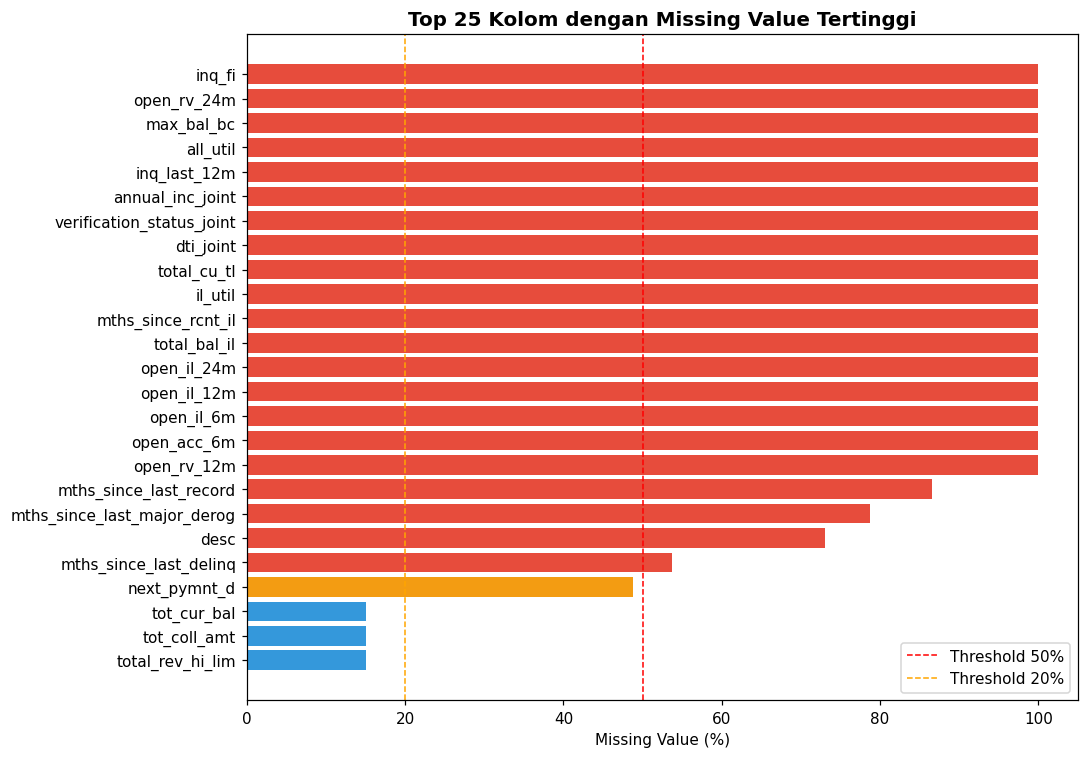

                      Kolom  Missing  Missing (%)
                     inq_fi   466285       100.00
                open_rv_24m   466285       100.00
                 max_bal_bc   466285       100.00
                   all_util   466285       100.00
               inq_last_12m   466285       100.00
           annual_inc_joint   466285       100.00
  verification_status_joint   466285       100.00
                  dti_joint   466285       100.00
                total_cu_tl   466285       100.00
                    il_util   466285       100.00
         mths_since_rcnt_il   466285       100.00
               total_bal_il   466285       100.00
                open_il_24m   466285       100.00
                open_il_12m   466285       100.00
                 open_il_6m   466285       100.00
                open_acc_6m   466285       100.00
                open_rv_12m   466285       100.00
     mths_since_last_record   403647        86.57
mths_since_last_major_derog   367311        78.77


In [86]:
missing = df.isnull().sum().reset_index()
missing.columns = ['Kolom', 'Missing']
missing['Missing (%)'] = (missing['Missing'] / len(df) * 100).round(2)
missing = missing[missing['Missing'] > 0].sort_values('Missing (%)', ascending=False)

print(f'Kolom dengan missing value : {len(missing)} dari {df.shape[1]} kolom')
print()

# Visualisasi top 25 missing
top_miss = missing.head(25)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(top_miss['Kolom'][::-1], top_miss['Missing (%)'][::-1],
               color=['#e74c3c' if x > 50 else '#f39c12' if x > 20 else '#3498db'
                      for x in top_miss['Missing (%)'][::-1]])
ax.axvline(50, color='red', linestyle='--', linewidth=1, label='Threshold 50%')
ax.axvline(20, color='orange', linestyle='--', linewidth=1, label='Threshold 20%')
ax.set_xlabel('Missing Value (%)')
ax.set_title('Top 25 Kolom dengan Missing Value Tertinggi', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(missing.head(20).to_string(index=False))

**B. Duplikat Data**

In [87]:
dup_count = df.duplicated().sum()
print(f'Jumlah baris duplikat : {dup_count:,}')

Jumlah baris duplikat : 0


**📌 Insight Data Understanding:**
- Dataset berisi **466.285 baris** dan **75 kolom** dengan komposisi 48 float, 5 int, 22 object
- Terdapat **banyak kolom dengan missing value tinggi** (>50%) yang perlu di-drop
- **Tidak ada data duplikat** sehingga tidak diperlukan penanganan khusus
- Kolom `loan_status` menjadi **sumber label target** `credit_risk` yang akan dibuat
- Status seperti *Charged Off*, *Default*, dan *Late* mengindikasikan peminjam berisiko tinggi

---
## 🔍 2. Exploratory Data Analysis (EDA)

> Tahap ini bertujuan untuk mengeksplorasi pola, distribusi, dan hubungan antar variabel secara visual dan statistik sebelum melakukan pemodelan.

### 2.1 Distribusi Fitur Numerik Utama

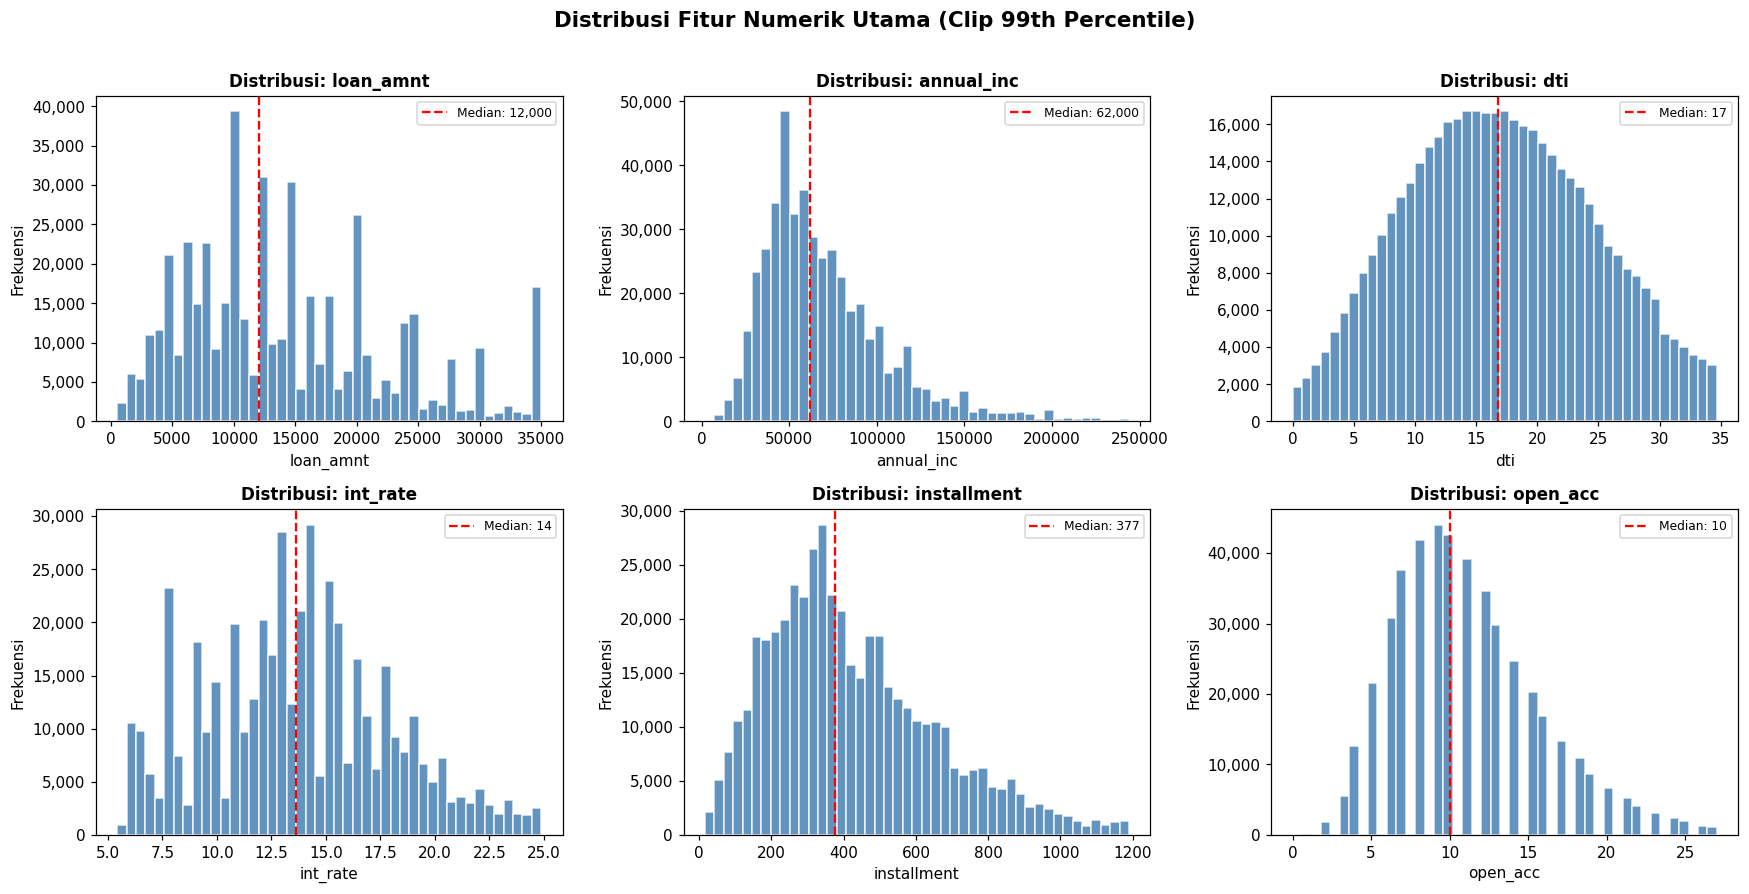

In [88]:
num_cols = ['loan_amnt', 'annual_inc', 'dti', 'int_rate', 'installment', 'open_acc']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    data = df[col].dropna()
    p99  = data.quantile(0.99)  # Clip outlier ekstrem untuk visualisasi
    data = data[data <= p99]

    axes[i].hist(data, bins=45, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i].axvline(data.median(), color='red', linestyle='--',
                    linewidth=1.5, label=f'Median: {data.median():,.0f}')
    axes[i].set_title(f'Distribusi: {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col); axes[i].set_ylabel('Frekuensi')
    axes[i].legend(fontsize=8)
    axes[i].yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.suptitle('Distribusi Fitur Numerik Utama (Clip 99th Percentile)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 2.2 Distribusi Fitur Kategorikal Utama

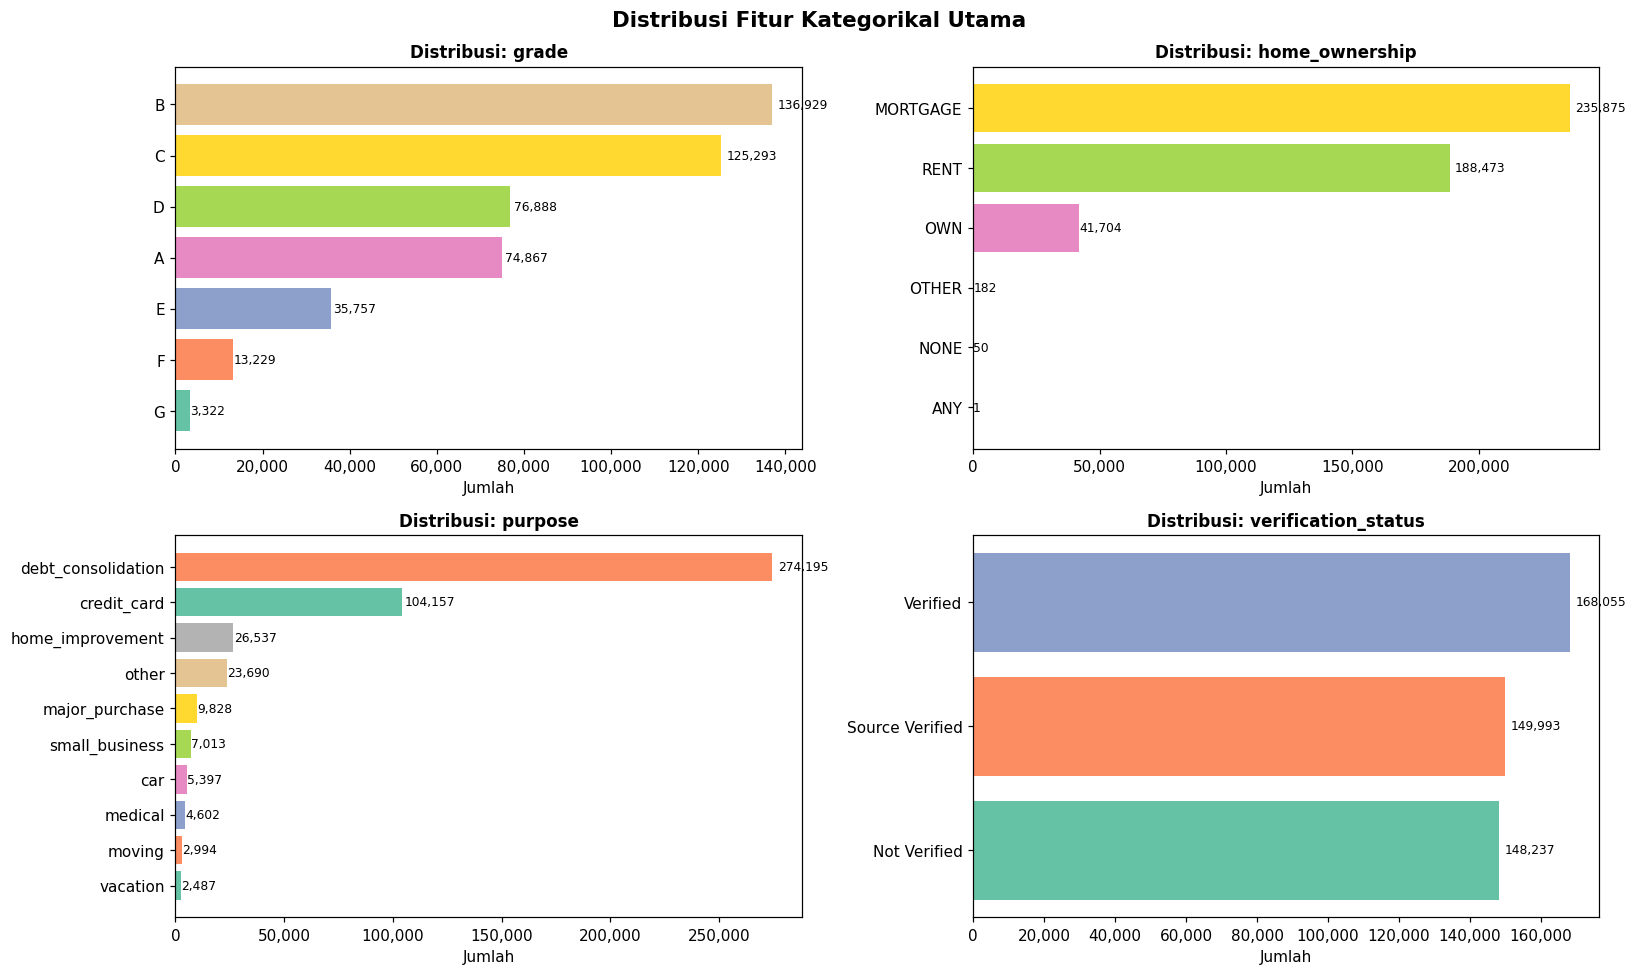

In [89]:
cat_cols = ['grade', 'home_ownership', 'purpose', 'verification_status']

fig, axes = plt.subplots(2, 2, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    vc = df[col].value_counts().head(10)
    colors_cat = sns.color_palette(PALETTE, len(vc))
    bars = axes[i].barh(vc.index[::-1], vc.values[::-1], color=colors_cat)
    axes[i].set_title(f'Distribusi: {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Jumlah')
    axes[i].xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    for bar in bars:
        w = bar.get_width()
        axes[i].text(w * 1.01, bar.get_y() + bar.get_height() / 2,
                     f'{w:,.0f}', va='center', fontsize=8)

plt.suptitle('Distribusi Fitur Kategorikal Utama', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3 Tren Jumlah Pinjaman Berdasarkan Waktu

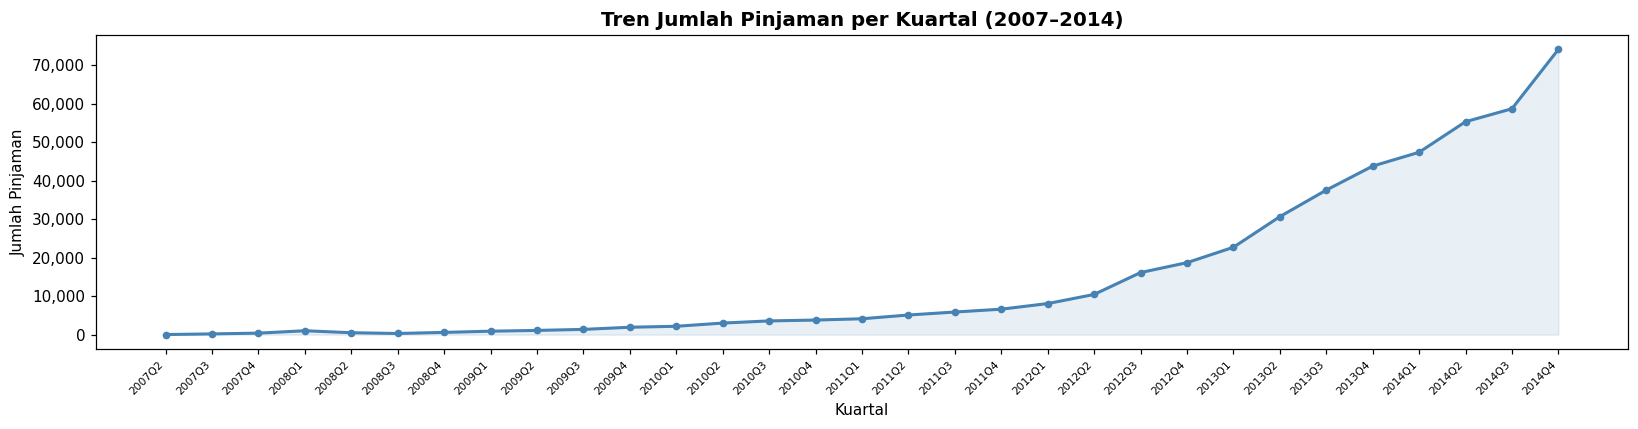

In [90]:
df_time = df[['issue_d']].copy()
df_time['issue_d'] = pd.to_datetime(df_time['issue_d'], format='%b-%y', errors='coerce')
df_time.dropna(inplace=True)

quarterly = df_time.groupby(df_time['issue_d'].dt.to_period('Q')).size()

fig, ax = plt.subplots(figsize=(15, 4))
x_vals = range(len(quarterly))
ax.plot(x_vals, quarterly.values, marker='o', linewidth=2,
        color='steelblue', markersize=4)
ax.fill_between(x_vals, quarterly.values, alpha=0.12, color='steelblue')
ax.set_title('Tren Jumlah Pinjaman per Kuartal (2007–2014)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Kuartal'); ax.set_ylabel('Jumlah Pinjaman')
ax.set_xticks(x_vals)
ax.set_xticklabels(quarterly.index.astype(str), rotation=45, ha='right', fontsize=7)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

### 2.4 Analisis Bivariat — Grade vs Loan Amount & Interest Rate

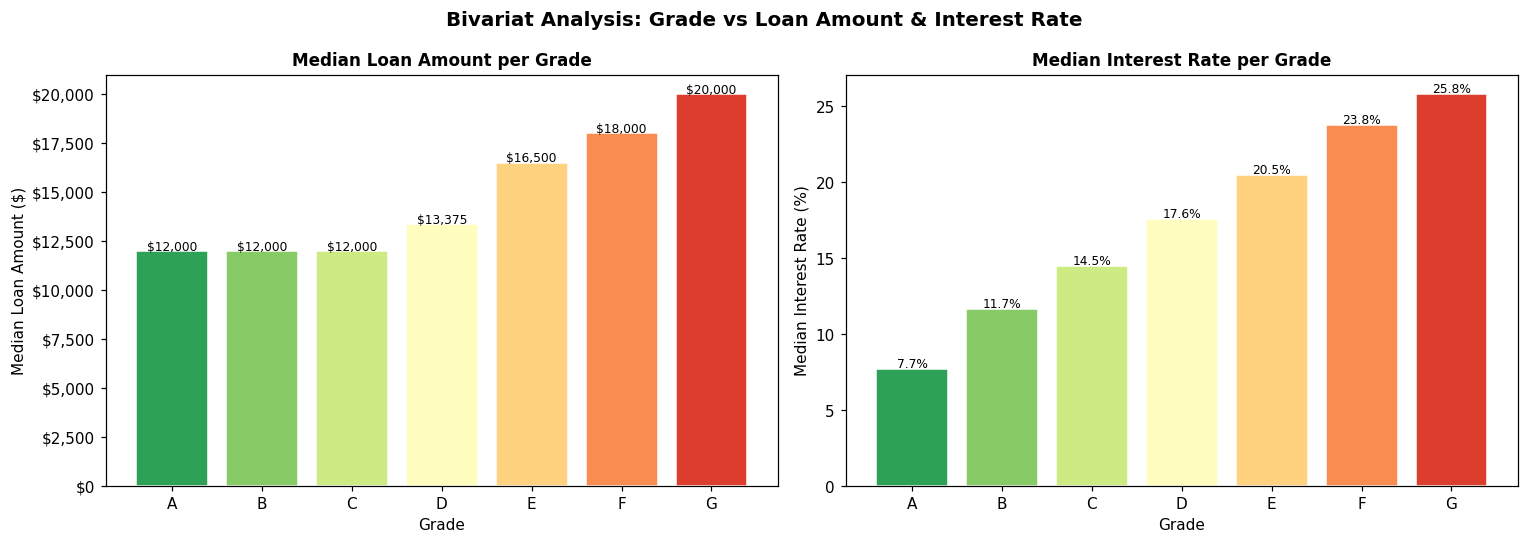

In [91]:
grade_order = sorted(df['grade'].dropna().unique())
palette_grade = sns.color_palette('RdYlGn_r', len(grade_order))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loan Amount per Grade
grade_loan = df.groupby('grade')['loan_amnt'].median().reindex(grade_order)
axes[0].bar(grade_loan.index, grade_loan.values, color=palette_grade, edgecolor='white')
axes[0].set_title('Median Loan Amount per Grade', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Grade'); axes[0].set_ylabel('Median Loan Amount ($)')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar in axes[0].patches:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'${bar.get_height():,.0f}', ha='center', fontsize=8)

# Interest Rate per Grade
grade_int = df.groupby('grade')['int_rate'].median().reindex(grade_order)
axes[1].bar(grade_int.index, grade_int.values, color=palette_grade, edgecolor='white')
axes[1].set_title('Median Interest Rate per Grade', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Grade'); axes[1].set_ylabel('Median Interest Rate (%)')
for bar in axes[1].patches:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{bar.get_height():.1f}%', ha='center', fontsize=8)

plt.suptitle('Bivariat Analysis: Grade vs Loan Amount & Interest Rate',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.5 Analisis Univariat — Distribusi Loan Amount (Range)

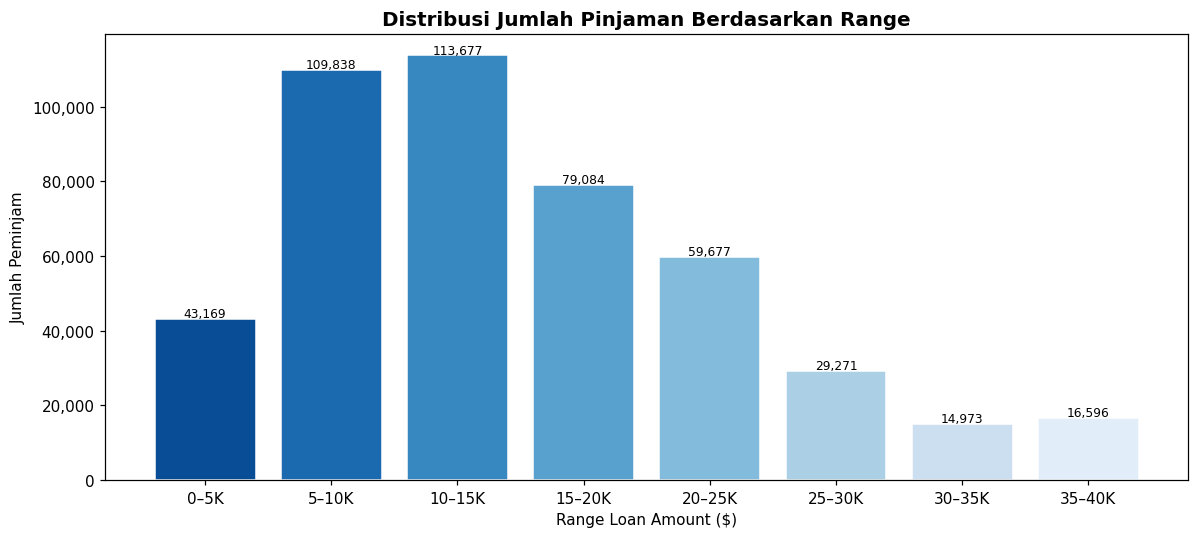

In [92]:
bins   = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
labels = ['0–5K', '5–10K', '10–15K', '15–20K', '20–25K', '25–30K', '30–35K', '35–40K']

loan_range = pd.cut(df['loan_amnt'], bins=bins, labels=labels, right=False)
loan_dist  = loan_range.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(11, 5))
colors_range = sns.color_palette('Blues_r', len(labels))
bars = ax.bar(loan_dist.index, loan_dist.values, color=colors_range, edgecolor='white')
ax.set_title('Distribusi Jumlah Pinjaman Berdasarkan Range', fontsize=13, fontweight='bold')
ax.set_xlabel('Range Loan Amount ($)'); ax.set_ylabel('Jumlah Peminjam')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{bar.get_height():,}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

### 2.6 Heatmap Korelasi Fitur Numerik

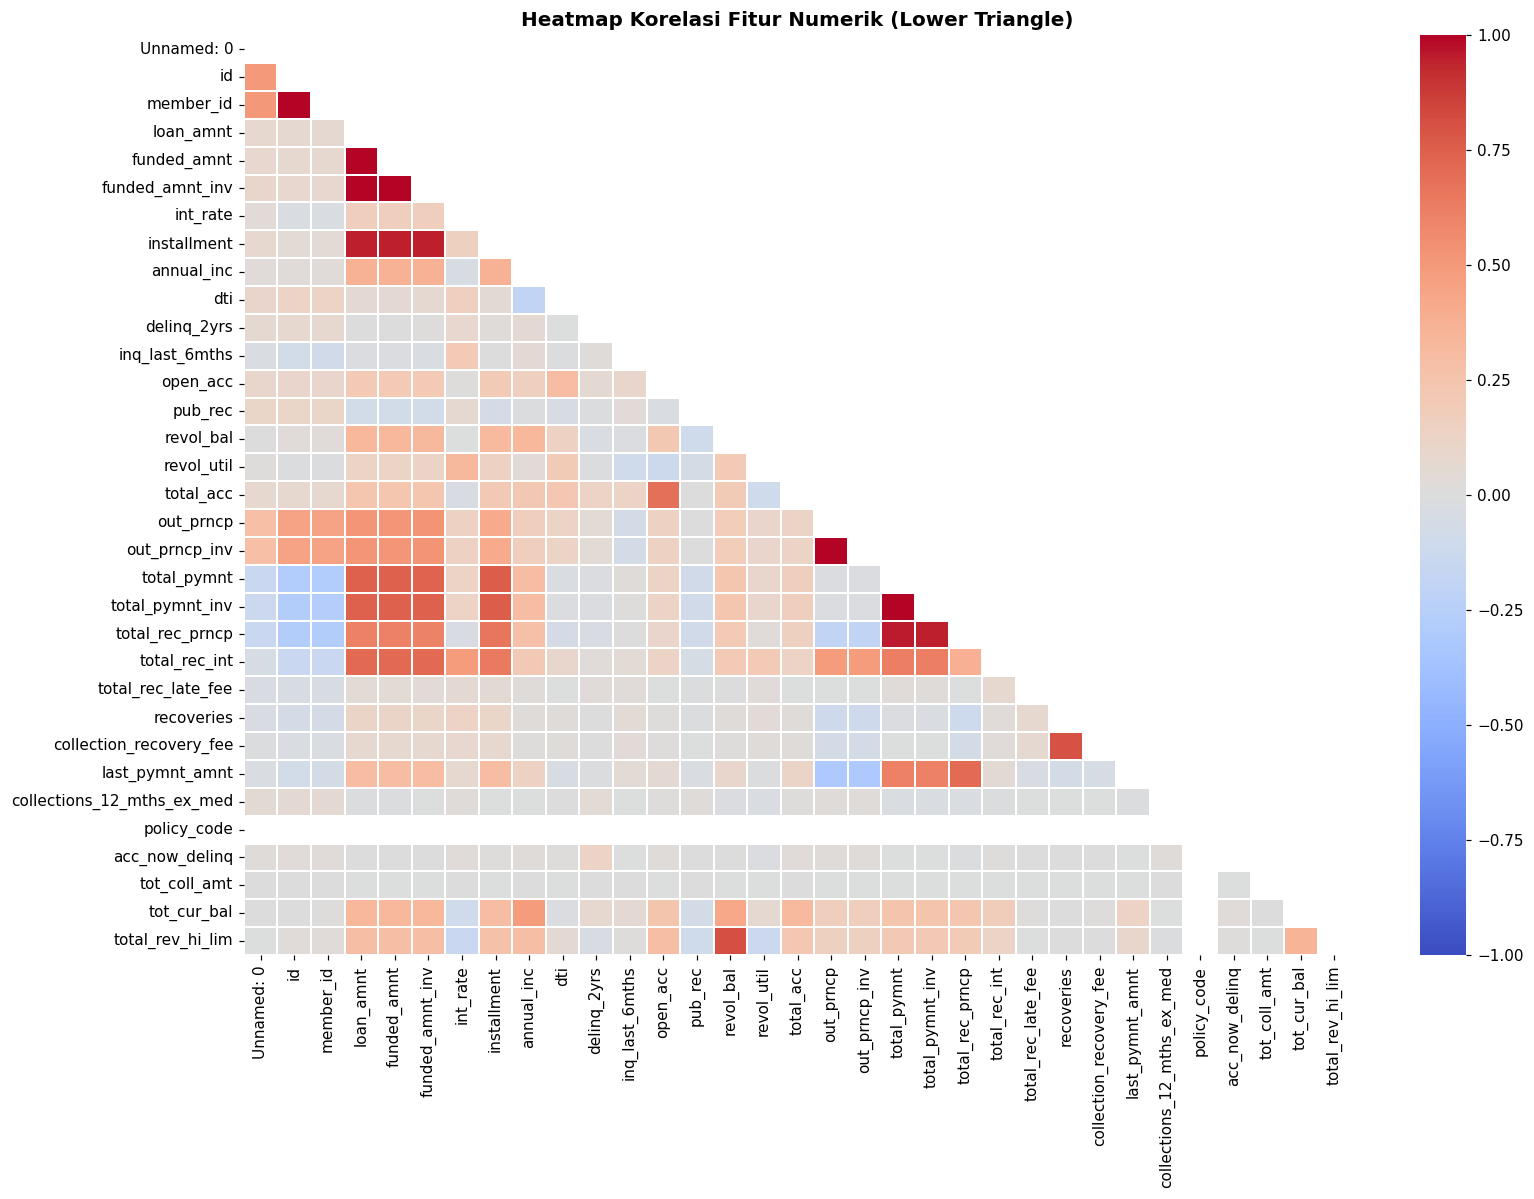

Pasangan fitur dengan korelasi ≥ 0.80 (akan ditangani saat Data Prep):
        Fitur 1                 Fitur 2  Korelasi
      out_prncp           out_prncp_inv     1.000
      loan_amnt             funded_amnt     0.999
             id               member_id     0.997
    total_pymnt         total_pymnt_inv     0.996
    funded_amnt         funded_amnt_inv     0.996
      loan_amnt         funded_amnt_inv     0.994
    total_pymnt         total_rec_prncp     0.957
total_pymnt_inv         total_rec_prncp     0.952
    funded_amnt             installment     0.952
      loan_amnt             installment     0.950
funded_amnt_inv             installment     0.947
      revol_bal        total_rev_hi_lim     0.810
     recoveries collection_recovery_fee     0.801


In [93]:
# Ambil kolom numerik yang memiliki setidaknya 50% data terisi
numeric_df = df.select_dtypes(include='number').dropna(
    axis=1, thresh=int(len(df) * 0.5))
corr_matrix = numeric_df.corr()

# Tampilkan hanya lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=0.3, ax=ax, vmin=-1, vmax=1)
ax.set_title('Heatmap Korelasi Fitur Numerik (Lower Triangle)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Tampilkan pasangan dengan korelasi tinggi
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) >= 0.80:
            high_corr.append({
                'Fitur 1': corr_matrix.columns[i],
                'Fitur 2': corr_matrix.columns[j],
                'Korelasi': round(val, 3)
            })

high_corr_df = pd.DataFrame(high_corr).sort_values(
    'Korelasi', key=abs, ascending=False)
print(f'Pasangan fitur dengan korelasi ≥ 0.80 (akan ditangani saat Data Prep):')
print(high_corr_df.to_string(index=False))

**📌 Insight EDA:**
- Distribusi Pinjaman: loan_amnt bersifat right-skewed dengan median $12,000. Terdapat konsentrasi tinggi pada pinjaman $5K–$15K dan lonjakan pada angka-angka nominal bulat.
- Segmentasi Risiko: Grade B dan C mendominasi pasar, mencerminkan portofolio yang fokus pada debitur risiko menengah.
- Logika Suku Bunga: Suku bunga berbanding lurus dengan risiko; Grade A memiliki median bunga terendah (7.7%) sementara Grade G mencapai yang tertinggi (25.8%).
- Profil Pengguna: Mayoritas peminjam memiliki status rumah MORTGAGE dan menggunakan dana tersebut untuk debt_consolidation.
- Multikolinearitas: Fitur seperti loan_amnt, funded_amnt, dan installment berkorelasi hampir sempurna ($r \approx 1.0$), sehingga diperlukan reduksi fitur agar model lebih stabil.
- Pertumbuhan: Tren volume pinjaman yang melonjak di 2013-2014 mengindikasikan fase ekspansi bisnis yang masif.

---
## 🛠️ 3. Data Preparation

> Tahap ini meliputi pembuatan label target, pembersihan data, feature engineering, encoding, handling imbalance, dan splitting dataset. Setiap langkah didokumentasikan beserta alasannya.

### 3.1 Pembuatan Label Target — `credit_risk`

Label dibuat berdasarkan kolom `loan_status` menggunakan logika domain multifinance:

| Label | Nilai | Kategori loan_status |
|:---:|:---:|---|
| **0** | Bad Risk | Charged Off, Default, Late (16-30 days), Late (31-120 days) |
| **1** | Good Risk | Fully Paid, Current, In Grace Period |

In [94]:
BAD_STATUS = [
    'Charged Off',
    'Default',
    'Late (31-120 days)',
    'Late (16-30 days)',
    'Does not meet the credit policy. Status:Charged Off'
]

GOOD_STATUS = [
    'Fully Paid',
    'Current',
    'In Grace Period',
    'Does not meet the credit policy. Status:Fully Paid'
]

def assign_credit_risk(status):
    """Mapping loan_status ke binary credit risk label."""
    if status in BAD_STATUS:
        return 0   # Bad Risk
    elif status in GOOD_STATUS:
        return 1   # Good Risk
    return np.nan  # Status tidak dikenal → akan di-drop

df['credit_risk'] = df['loan_status'].map(assign_credit_risk)

# Hapus baris yang tidak terklasifikasi
df.dropna(subset=['credit_risk'], inplace=True)
df['credit_risk'] = df['credit_risk'].astype(int)

print('Distribusi credit_risk setelah pelabelan:')
print('-' * 40)
vc = df['credit_risk'].value_counts()
print(f'  Good Risk (1) : {vc[1]:>7,}  ({vc[1]/len(df)*100:.2f}%)')
print(f'  Bad  Risk (0) : {vc[0]:>7,}  ({vc[0]/len(df)*100:.2f}%)')
print(f'  Total         : {len(df):>7,}')

Distribusi credit_risk setelah pelabelan:
----------------------------------------
  Good Risk (1) : 414,099  (88.81%)
  Bad  Risk (0) :  52,186  (11.19%)
  Total         : 466,285


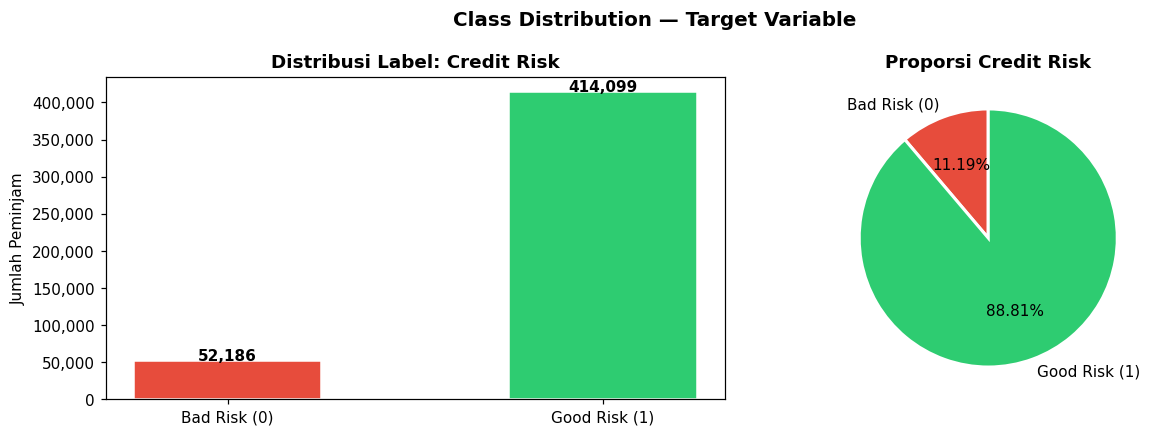

  Dataset imbalanced — akan ditangani dengan RandomUnderSampler setelah split


In [95]:
# Visualisasi distribusi label target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

clr = ['#e74c3c', '#2ecc71']
vc_plot = df['credit_risk'].value_counts()

# Bar chart
axes[0].bar(['Bad Risk (0)', 'Good Risk (1)'],
            [vc_plot[0], vc_plot[1]], color=clr, edgecolor='white', width=0.5)
axes[0].set_title('Distribusi Label: Credit Risk', fontweight='bold')
axes[0].set_ylabel('Jumlah Peminjam')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for i, v in enumerate([vc_plot[0], vc_plot[1]]):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold', fontsize=10)

# Pie chart
axes[1].pie([vc_plot[0], vc_plot[1]],
            labels=['Bad Risk (0)', 'Good Risk (1)'],
            colors=clr, autopct='%1.2f%%', startangle=90,
            wedgeprops=dict(edgecolor='white', linewidth=2),
            textprops={'fontsize': 10})
axes[1].set_title('Proporsi Credit Risk', fontweight='bold')

plt.suptitle('Class Distribution — Target Variable', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('  Dataset imbalanced — akan ditangani dengan RandomUnderSampler setelah split')

### 3.2 Drop Kolom Tidak Relevan & Redundan

In [96]:
# Definisi kolom yang di-drop beserta alasan
irrelevant_cols = {
    'Unnamed: 0'      : 'Index duplikat, tidak informatif',
    'id'              : 'ID unik peminjam, tidak berkontribusi pada model',
    'member_id'       : 'ID unik member, tidak berkontribusi pada model',
    'url'             : 'URL link, tidak relevan untuk analisis',
    'desc'            : 'Teks deskripsi bebas, kardinalitas sangat tinggi',
    'zip_code'        : 'Granularitas terlalu tinggi, rentan overfitting',
    'emp_title'       : 'Teks bebas, kardinalitas sangat tinggi',
    'title'           : 'Teks bebas duplikat informasi dari purpose',
    'policy_code'     : 'Nilai tunggal (no variance)',
    'application_type': 'Nilai tunggal (Individual saja)',
    'loan_status'     : 'Sumber label — harus di-drop (data leakage)',
}

cols_to_drop = [c for c in irrelevant_cols if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

print('Kolom yang di-drop:')
for col in cols_to_drop:
    print(f'  ✗ {col:<20} → {irrelevant_cols[col]}')
print(f'\nJumlah kolom setelah drop: {df.shape[1]}')

Kolom yang di-drop:
  ✗ Unnamed: 0           → Index duplikat, tidak informatif
  ✗ id                   → ID unik peminjam, tidak berkontribusi pada model
  ✗ member_id            → ID unik member, tidak berkontribusi pada model
  ✗ url                  → URL link, tidak relevan untuk analisis
  ✗ desc                 → Teks deskripsi bebas, kardinalitas sangat tinggi
  ✗ zip_code             → Granularitas terlalu tinggi, rentan overfitting
  ✗ emp_title            → Teks bebas, kardinalitas sangat tinggi
  ✗ title                → Teks bebas duplikat informasi dari purpose
  ✗ policy_code          → Nilai tunggal (no variance)
  ✗ application_type     → Nilai tunggal (Individual saja)
  ✗ loan_status          → Sumber label — harus di-drop (data leakage)

Jumlah kolom setelah drop: 65


### 3.3 Handle Missing Values

In [97]:
# Step 1: Drop kolom dengan missing value > 40%
miss_pct = df.isnull().sum() / len(df) * 100
cols_high_miss = miss_pct[miss_pct > 40].index.tolist()
df.drop(columns=cols_high_miss, inplace=True)

print(f'Kolom dengan missing >40% di-drop  : {len(cols_high_miss)} kolom')
print(f'Kolom tersisa                       : {df.shape[1]}')

Kolom dengan missing >40% di-drop  : 21 kolom
Kolom tersisa                       : 44


In [98]:
# Step 2: Konversi kolom tanggal
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d',
             'last_credit_pull_d', 'next_pymnt_d']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%b-%y', errors='coerce')

# Step 3: Imputasi median untuk kolom numerik (missing < 20%)
num_cols_miss = df.select_dtypes(include='number').columns[
    df.select_dtypes(include='number').isnull().any()]
for col in num_cols_miss:
    if df[col].isnull().mean() < 0.20:
        df[col].fillna(df[col].median(), inplace=True)

# Step 4: Imputasi median untuk kolom tanggal
for col in date_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Step 5: Imputasi modus untuk kolom kategorikal
cat_cols_miss = df.select_dtypes(include='object').columns[
    df.select_dtypes(include='object').isnull().any()]
for col in cat_cols_miss:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Step 6: Drop sisa baris yang masih memiliki missing
before = len(df)
df.dropna(inplace=True)

print('Strategi imputasi yang diterapkan:')
print('  - Kolom numerik  (missing <20%) → diisi Median')
print('  - Kolom datetime               → diisi Median')
print('  - Kolom kategorikal            → diisi Modus')
print('  - Sisa baris dengan NaN        → di-drop')
print(f'\nBaris sebelum dropna : {before:,}')
print(f'Baris setelah dropna : {len(df):,}')
print(f'Sisa missing value   : {df.isnull().sum().sum()}')

Strategi imputasi yang diterapkan:
  - Kolom numerik  (missing <20%) → diisi Median
  - Kolom datetime               → diisi Median
  - Kolom kategorikal            → diisi Modus
  - Sisa baris dengan NaN        → di-drop

Baris sebelum dropna : 466,285
Baris setelah dropna : 466,285
Sisa missing value   : 0


### 3.4 Feature Engineering

**A. Reduksi Multikolinearitas**  
Drop salah satu kolom dari setiap pasangan berkorelasi ≥ 0.80 untuk mengurangi redundansi informasi.

In [99]:
# Kolom yang di-drop karena multikolinearitas beserta alasannya
multicollinear_drops = {
    'funded_amnt'           : 'Korelasi ~1.00 dengan loan_amnt (lebih informatif)',
    'funded_amnt_inv'       : 'Korelasi ~1.00 dengan loan_amnt',
    'installment'           : 'Derived dari loan_amnt & int_rate',
    'out_prncp_inv'         : 'Korelasi tinggi dengan out_prncp',
    'total_pymnt_inv'       : 'Korelasi tinggi dengan total_pymnt',
    'total_rec_prncp'       : 'Korelasi tinggi dengan total_pymnt',
    'collection_recovery_fee': 'Korelasi tinggi dengan recoveries',
}

cols_to_drop_mc = [c for c in multicollinear_drops if c in df.columns]
df.drop(columns=cols_to_drop_mc, inplace=True)

print('Kolom multikolinear yang di-drop:')
for col in cols_to_drop_mc:
    print(f'  ✗ {col:<30} → {multicollinear_drops[col]}')
print(f'\nJumlah kolom tersisa: {df.shape[1]}')

Kolom multikolinear yang di-drop:
  ✗ funded_amnt                    → Korelasi ~1.00 dengan loan_amnt (lebih informatif)
  ✗ funded_amnt_inv                → Korelasi ~1.00 dengan loan_amnt
  ✗ installment                    → Derived dari loan_amnt & int_rate
  ✗ out_prncp_inv                  → Korelasi tinggi dengan out_prncp
  ✗ total_pymnt_inv                → Korelasi tinggi dengan total_pymnt
  ✗ total_rec_prncp                → Korelasi tinggi dengan total_pymnt
  ✗ collection_recovery_fee        → Korelasi tinggi dengan recoveries

Jumlah kolom tersisa: 37


**B. Konversi Tipe Data**

In [100]:
# Ekstrak angka dari kolom 'term' → ' 36 months' menjadi 36.0
if 'term' in df.columns:
    df['term'] = df['term'].str.extract(r'(\d+)').astype(float)
    print("'term' dikonversi ke numerik:", df['term'].unique())

# Drop kolom datetime (tidak bisa dipakai langsung oleh model tree/linear)
date_cols_in_df = [c for c in date_cols if c in df.columns]
df.drop(columns=date_cols_in_df, inplace=True)

print(f'\nKolom datetime di-drop: {date_cols_in_df}')
print(f'Shape setelah konversi: {df.shape}')
print(f'Kolom object tersisa  : {list(df.select_dtypes("object").columns)}')

'term' dikonversi ke numerik: [36. 60.]

Kolom datetime di-drop: ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
Shape setelah konversi: (466285, 33)
Kolom object tersisa  : ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status']


### 3.5 Encoding Variabel Kategorikal

- **Ordinal Encoding** → fitur dengan urutan/hierarki alami (`grade`, `sub_grade`, `emp_length`, `verification_status`)
- **Label Encoding** → fitur nominal tanpa hierarki (`home_ownership`, `purpose`, dll.)

In [101]:
# Ordinal Encoding — fitur dengan hierarki jelas
ordinal_maps = {
    'grade': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7},
    'sub_grade': {
        f'{g}{n}': (ord(g) - ord('A')) * 5 + n
        for g in 'ABCDEFG' for n in range(1, 6)
    },
    'emp_length': {
        '< 1 year': 0, '1 year': 1, '2 years': 2,  '3 years': 3,
        '4 years': 4,  '5 years': 5, '6 years': 6, '7 years': 7,
        '8 years': 8,  '9 years': 9, '10+ years': 10
    },
    'verification_status': {
        'Not Verified': 0, 'Source Verified': 1, 'Verified': 2
    },
}

for col, mapping in ordinal_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
        print(f'  Ordinal encoded: {col}')

# Label Encoding — fitur nominal
nominal_cols = [c for c in df.select_dtypes('object').columns
                if c != 'credit_risk']
le = LabelEncoder()
for col in nominal_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    print(f'  Label encoded  : {col}')

print(f'\nKolom object tersisa: {df.select_dtypes("object").columns.tolist()}')
print(f'Shape final dataset : {df.shape}')

  Ordinal encoded: grade
  Ordinal encoded: sub_grade
  Ordinal encoded: emp_length
  Ordinal encoded: verification_status
  Label encoded  : home_ownership
  Label encoded  : pymnt_plan
  Label encoded  : purpose
  Label encoded  : addr_state
  Label encoded  : initial_list_status

Kolom object tersisa: []
Shape final dataset : (466285, 33)


### 3.6 Train-Test Split (80:20, Stratified)

In [102]:
X = df.drop(columns=['credit_risk'])
y = df['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y          # Menjaga proporsi kelas pada train & test
)

print('=== Train-Test Split ===')
print(f'Total data   : {len(X):>7,}')
print(f'Training set : {X_train.shape[0]:>7,}  ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test set     : {X_test.shape[0]:>7,}  ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'Fitur        : {X_train.shape[1]}')
print(f'\nDistribusi y_train : {dict(y_train.value_counts().sort_index())}')
print(f'Distribusi y_test  : {dict(y_test.value_counts().sort_index())}')

=== Train-Test Split ===
Total data   : 466,285
Training set : 373,028  (80%)
Test set     :  93,257  (20%)
Fitur        : 32

Distribusi y_train : {0: np.int64(41749), 1: np.int64(331279)}
Distribusi y_test  : {0: np.int64(10437), 1: np.int64(82820)}


### 3.7 Handling Imbalanced Data — RandomUnderSampler

> **Alasan memilih RandomUnderSampler:**  
> Dataset berukuran sangat besar (>300K baris pada training). Undersampling lebih efisien secara komputasi dibandingkan SMOTE, dan menghindari risiko overfitting dari data sintetik. Diterapkan **hanya pada data training** — data testing dibiarkan imbalanced agar mencerminkan distribusi nyata.

In [103]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print('Distribusi kelas sebelum resampling:')
print(f'  Bad (0)  : {y_train.value_counts()[0]:>7,}')
print(f'  Good (1) : {y_train.value_counts()[1]:>7,}')
print(f'\nDistribusi kelas setelah RandomUnderSampling:')
vc_res = pd.Series(y_train_res).value_counts().sort_index()
print(f'  Bad (0)  : {vc_res[0]:>7,}')
print(f'  Good (1) : {vc_res[1]:>7,}')

Distribusi kelas sebelum resampling:
  Bad (0)  :  41,749
  Good (1) : 331,279

Distribusi kelas setelah RandomUnderSampling:
  Bad (0)  :  41,749
  Good (1) :  83,498


### 3.8 Feature Scaling — StandardScaler

> Scaling diperlukan terutama untuk Logistic Regression yang sensitif terhadap skala fitur. Scaler di-fit hanya pada data training (`fit_transform`) dan diterapkan ke data test (`transform`) untuk menghindari **data leakage**.

In [104]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_res)   # fit + transform pada train
X_test_scaled  = scaler.transform(X_test)             # transform saja pada test

# Konversi kembali ke DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X.columns)

print(f'X_train_scaled : {X_train_scaled.shape}')
print(f'X_test_scaled  : {X_test_scaled.shape}')
print('\n Data Preparation selesai')

X_train_scaled : (125247, 32)
X_test_scaled  : (93257, 32)

 Data Preparation selesai


---
## 🤖 4. Data Modelling

> Lima algoritma machine learning dilatih dan dievaluasi. Setiap model menggunakan **5-Fold Stratified Cross-Validation** untuk memastikan generalisasi yang baik dan mendeteksi overfitting.

**Helper Function — Evaluasi Terpadu**

In [105]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name='Model'):
    """
    Melatih model, memprediksi, dan menampilkan evaluasi lengkap.

    Parameters:
        model      : Sklearn-compatible model
        X_tr, y_tr : Training data
        X_te, y_te : Test data
        model_name : Nama model untuk label output

    Returns:
        (metrics_dict, fitted_model, y_pred, y_proba)
    """
    # Training
    model.fit(X_tr, y_tr)

    # Prediksi
    y_pred  = model.predict(X_te)
    y_proba = (model.predict_proba(X_te)[:, 1]
               if hasattr(model, 'predict_proba') else None)

    # Metrik utama
    acc   = accuracy_score(y_te, y_pred)
    prec  = precision_score(y_te, y_pred, zero_division=0)
    rec   = recall_score(y_te, y_pred, zero_division=0)
    f1    = f1_score(y_te, y_pred, zero_division=0)
    auc   = roc_auc_score(y_te, y_proba) if y_proba is not None else None

    # Cross-validation (5-fold stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_tr, y_tr,
                                cv=cv, scoring='f1', n_jobs=-1)

    # Print hasil
    print(f'\n{"━"*55}')
    print(f'  {model_name}')
    print(f'{"━"*55}')
    print(f'  Accuracy     : {acc:.4f}')
    print(f'  Precision    : {prec:.4f}')
    print(f'  Recall       : {rec:.4f}')
    print(f'  F1-Score     : {f1:.4f}')
    if auc:
        print(f'  ROC-AUC      : {auc:.4f}')
    print(f'  CV F1 (mean) : {cv_scores.mean():.4f}  ± {cv_scores.std():.4f}')
    print()
    print('  Classification Report:')
    print(classification_report(y_te, y_pred,
                                 target_names=['Bad (0)', 'Good (1)'],
                                 digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt=',', cmap='Blues',
                xticklabels=['Bad', 'Good'],
                yticklabels=['Bad', 'Good'],
                annot_kws={'size': 12})
    plt.title(f'Confusion Matrix\n{model_name}', fontweight='bold')
    plt.ylabel('Actual'); plt.xlabel('Predicted')
    plt.tight_layout(); plt.show()

    return {
        'Model'     : model_name,
        'Accuracy'  : round(acc, 4),
        'Precision' : round(prec, 4),
        'Recall'    : round(rec, 4),
        'F1-Score'  : round(f1, 4),
        'ROC-AUC'   : round(auc, 4) if auc else None,
        'CV F1 Mean': round(cv_scores.mean(), 4),
        'CV F1 Std' : round(cv_scores.std(), 4),
    }, model, y_pred, y_proba


results = []   # Menyimpan metrik semua model
print(' Helper function evaluate_model() siap digunakan')

 Helper function evaluate_model() siap digunakan


### 4.1 Logistic Regression *(Baseline — Model Wajib)*

> Model linear probabilistik yang menghasilkan probabilitas class menggunakan fungsi sigmoid. Dipilih sebagai **baseline** karena sangat interpretable, cepat, dan menjadi rujukan awal untuk menilai apakah model kompleks memberikan peningkatan yang signifikan.
>
> **Parameter:** `class_weight='balanced'` → menangani imbalance secara internal, `solver='lbfgs'` → optimal untuk dataset sedang-besar.


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Logistic Regression
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy     : 0.9690
  Precision    : 0.9812
  Recall       : 0.9840
  F1-Score     : 0.9826
  ROC-AUC      : 0.9685
  CV F1 (mean) : 0.9549  ± 0.0009

  Classification Report:
              precision    recall  f1-score   support

     Bad (0)     0.8698    0.8501    0.8598     10437
    Good (1)     0.9812    0.9840    0.9826     82820

    accuracy                         0.9690     93257
   macro avg     0.9255    0.9170    0.9212     93257
weighted avg     0.9687    0.9690    0.9688     93257



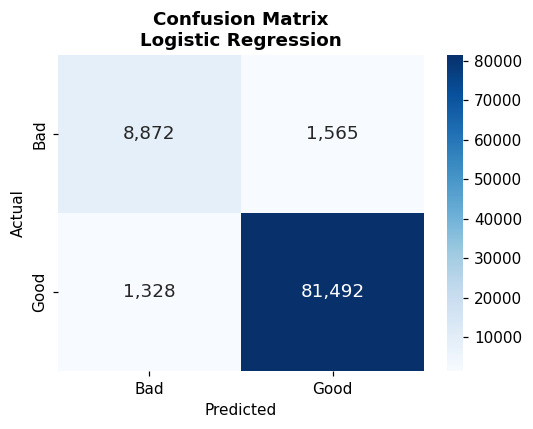

In [106]:
lr_model = LogisticRegression(
    max_iter=500,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

lr_result, lr_fitted, lr_pred, lr_proba = evaluate_model(
    lr_model,
    X_train_scaled, y_train_res,
    X_test_scaled, y_test,
    'Logistic Regression'
)
results.append(lr_result)

### 4.2 Decision Tree

> Model pohon keputusan yang bekerja dengan **membagi data secara rekursif** berdasarkan fitur dan threshold yang menghasilkan pemisahan paling murni (criterion: Gini Impurity). Keunggulannya adalah sangat mudah divisualisasikan dan diinterpretasi oleh non-teknis.
>
> **Risiko:** Tanpa pembatasan kedalaman, Decision Tree cenderung **overfit** pada data training. Parameter `max_depth`, `min_samples_split`, dan `min_samples_leaf` dikontrol untuk menjaga generalisasi.


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Decision Tree
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy     : 0.9653
  Precision    : 0.9822
  Recall       : 0.9787
  F1-Score     : 0.9804
  ROC-AUC      : 0.9653
  CV F1 (mean) : 0.9548  ± 0.0016

  Classification Report:
              precision    recall  f1-score   support

     Bad (0)     0.8355    0.8593    0.8473     10437
    Good (1)     0.9822    0.9787    0.9804     82820

    accuracy                         0.9653     93257
   macro avg     0.9089    0.9190    0.9138     93257
weighted avg     0.9658    0.9653    0.9655     93257



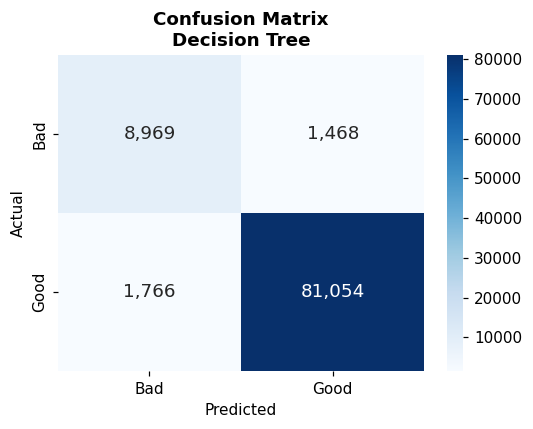

In [107]:
dt_model = DecisionTreeClassifier(
    max_depth=10,           # Batasi kedalaman pohon untuk mencegah overfitting
    min_samples_split=20,   # Min sampel yang dibutuhkan untuk split node
    min_samples_leaf=10,    # Min sampel pada leaf node
    criterion='gini',       # Gini Impurity sebagai kriteria pemisahan
    class_weight='balanced',
    random_state=42
)

dt_result, dt_fitted, dt_pred, dt_proba = evaluate_model(
    dt_model,
    X_train_scaled, y_train_res,
    X_test_scaled, y_test,
    'Decision Tree'
)
results.append(dt_result)

### 4.3 Random Forest

> Ensemble model yang membangun **banyak Decision Tree secara paralel** dengan teknik bagging (bootstrap aggregating) dan memilih prediksi melalui voting mayoritas. Random Forest lebih robust terhadap overfitting dibandingkan Decision Tree tunggal karena setiap tree hanya melihat subset fitur dan data.
>
> **Parameter:** `n_estimators=200` → 200 pohon, `max_depth=15` → mencegah overfitting, `n_jobs=-1` → paralel processing.


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Random Forest
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy     : 0.9741
  Precision    : 0.9820
  Recall       : 0.9890
  F1-Score     : 0.9855
  ROC-AUC      : 0.9691
  CV F1 (mean) : 0.9576  ± 0.0007

  Classification Report:
              precision    recall  f1-score   support

     Bad (0)     0.9075    0.8558    0.8809     10437
    Good (1)     0.9820    0.9890    0.9855     82820

    accuracy                         0.9741     93257
   macro avg     0.9447    0.9224    0.9332     93257
weighted avg     0.9736    0.9741    0.9738     93257



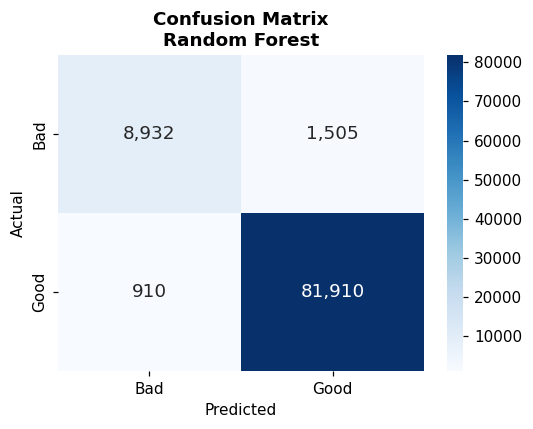

In [108]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_result, rf_fitted, rf_pred, rf_proba = evaluate_model(
    rf_model,
    X_train_scaled, y_train_res,
    X_test_scaled, y_test,
    'Random Forest'
)
results.append(rf_result)

### 4.4 Gradient Boosting

> Model boosting yang membangun tree **secara sekuensial**, di mana setiap tree baru fokus memperbaiki kesalahan dari tree sebelumnya. Berbeda dengan Random Forest yang membangun tree secara paralel, Gradient Boosting mengoptimalkan loss function secara bertahap.
>
> **Parameter:** `learning_rate=0.05` → langkah kecil untuk konvergensi yang stabil, `subsample=0.8` → mencegah overfitting dengan stochastic boosting.


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Gradient Boosting
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy     : 0.9786
  Precision    : 0.9819
  Recall       : 0.9943
  F1-Score     : 0.9880
  ROC-AUC      : 0.9735
  CV F1 (mean) : 0.9607  ± 0.0007

  Classification Report:
              precision    recall  f1-score   support

     Bad (0)     0.9496    0.8543    0.8994     10437
    Good (1)     0.9819    0.9943    0.9880     82820

    accuracy                         0.9786     93257
   macro avg     0.9657    0.9243    0.9437     93257
weighted avg     0.9783    0.9786    0.9781     93257



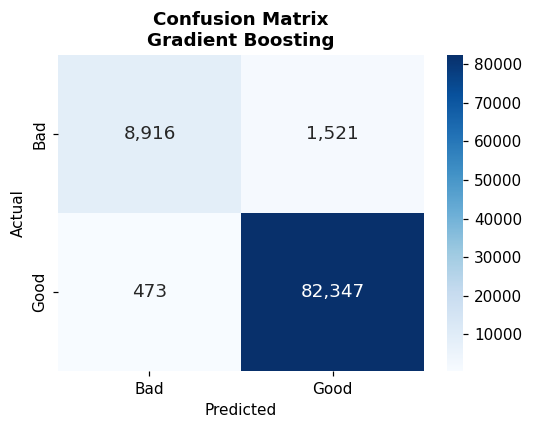

In [109]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gb_result, gb_fitted, gb_pred, gb_proba = evaluate_model(
    gb_model,
    X_train_scaled, y_train_res,
    X_test_scaled, y_test,
    'Gradient Boosting'
)
results.append(gb_result)

### 4.5 XGBoost

> Implementasi gradient boosting yang sangat dioptimalkan dengan fitur tambahan: **regularisasi L1/L2 built-in** untuk mencegah overfitting, **penanganan missing value otomatis**, dan kemampuan komputasi paralel yang efisien.
>
> **Parameter:** `scale_pos_weight` → rasio kelas negatif/positif untuk penanganan imbalance secara internal, `colsample_bytree=0.8` → random subspace method.

scale_pos_weight = 0.5000  (neg: 41,749 / pos: 83,498)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  XGBoost
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Accuracy     : 0.9765
  Precision    : 0.9844
  Recall       : 0.9893
  F1-Score     : 0.9868
  ROC-AUC      : 0.9772
  CV F1 (mean) : 0.9630  ± 0.0007

  Classification Report:
              precision    recall  f1-score   support

     Bad (0)     0.9115    0.8754    0.8931     10437
    Good (1)     0.9844    0.9893    0.9868     82820

    accuracy                         0.9765     93257
   macro avg     0.9479    0.9324    0.9400     93257
weighted avg     0.9762    0.9765    0.9763     93257



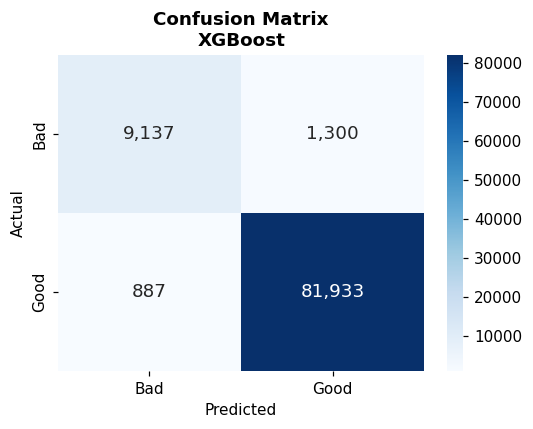

In [110]:
# Hitung scale_pos_weight dari data training yang telah di-resample
neg_count = int((y_train_res == 0).sum())
pos_count = int((y_train_res == 1).sum())
scale_pos = neg_count / pos_count
print(f'scale_pos_weight = {scale_pos:.4f}  (neg: {neg_count:,} / pos: {pos_count:,})')

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_result, xgb_fitted, xgb_pred, xgb_proba = evaluate_model(
    xgb_model,
    X_train_scaled, y_train_res,
    X_test_scaled, y_test,
    'XGBoost'
)
results.append(xgb_result)

---
## 📊 5. Model Evaluation & Comparison

> Tahap evaluasi membandingkan performa seluruh model secara komprehensif menggunakan berbagai metrik dan visualisasi untuk menentukan model terbaik yang layak diterapkan di lingkungan produksi.

### 5.1 Tabel Perbandingan Semua Model

In [111]:
results_df = pd.DataFrame(results).set_index('Model')

print('=== TABEL PERBANDINGAN PERFORMA MODEL ===')
print(results_df.to_string())

# Styled untuk Jupyter
results_df.style\
    .highlight_max(axis=0, color='#aaffaa')\
    .highlight_min(axis=0, color='#ffaaaa')\
    .format('{:.4f}', subset=['Accuracy', 'Precision', 'Recall',
                               'F1-Score', 'ROC-AUC', 'CV F1 Mean', 'CV F1 Std'])

=== TABEL PERBANDINGAN PERFORMA MODEL ===
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV F1 Mean  CV F1 Std
Model                                                                                     
Logistic Regression    0.9690     0.9812  0.9840    0.9826   0.9685      0.9549     0.0009
Decision Tree          0.9653     0.9822  0.9787    0.9804   0.9653      0.9548     0.0016
Random Forest          0.9741     0.9820  0.9890    0.9855   0.9691      0.9576     0.0007
Gradient Boosting      0.9786     0.9819  0.9943    0.9880   0.9735      0.9607     0.0007
XGBoost                0.9765     0.9844  0.9893    0.9868   0.9772      0.9630     0.0007


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV F1 Mean,CV F1 Std
Model,,,,,,,
Logistic Regression,0.9690,0.9812,0.9840,0.9826,0.9685,0.9549,0.0009
Decision Tree,0.9653,0.9822,0.9787,0.9804,0.9653,0.9548,0.0016
Random Forest,0.9741,0.9820,0.9890,0.9855,0.9691,0.9576,0.0007
Gradient Boosting,0.9786,0.9819,0.9943,0.9880,0.9735,0.9607,0.0007
XGBoost,0.9765,0.9844,0.9893,0.9868,0.9772,0.9630,0.0007


### 5.2 Visualisasi Perbandingan Metrik Utama

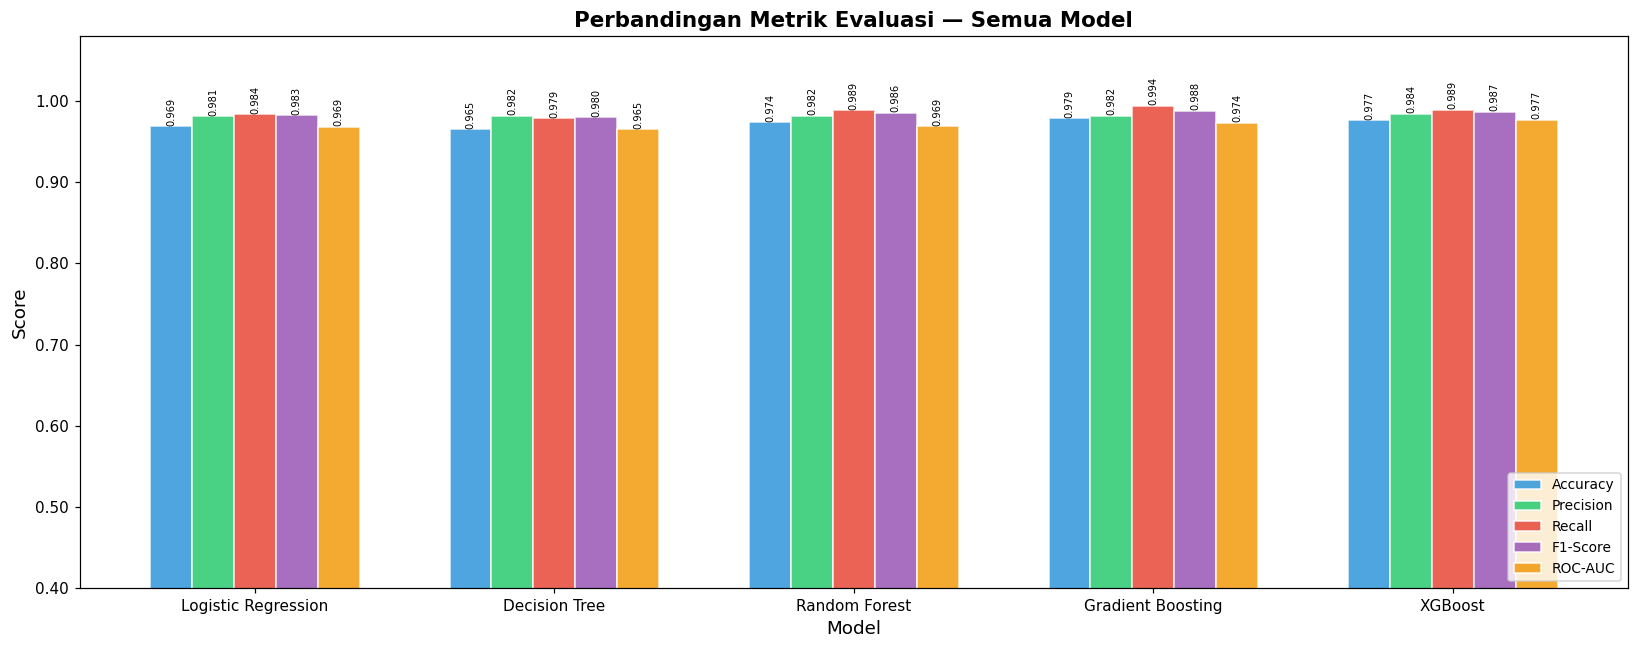

In [112]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
model_names = results_df.index.tolist()
x = np.arange(len(model_names))
bar_w = 0.14
bar_colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

fig, ax = plt.subplots(figsize=(15, 6))

for i, metric in enumerate(metrics_to_plot):
    vals = results_df[metric].values
    pos  = x + i * bar_w
    bars = ax.bar(pos, vals, bar_w, label=metric,
                  color=bar_colors[i], alpha=0.87, edgecolor='white')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.003,
                f'{val:.3f}', ha='center', fontsize=6.5, rotation=90)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Perbandingan Metrik Evaluasi — Semua Model',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + bar_w * (len(metrics_to_plot) - 1) / 2)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylim(0.4, 1.08)
ax.legend(loc='lower right', fontsize=9)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f'{v:.2f}'))
plt.tight_layout()
plt.show()

### 5.3 ROC Curve — Semua Model

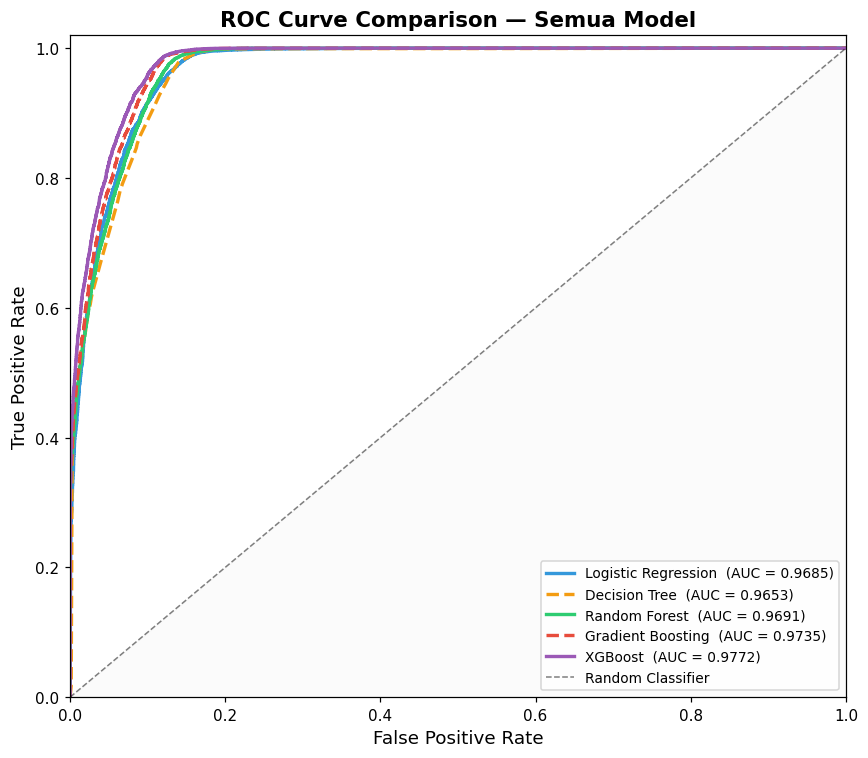

In [113]:
fig, ax = plt.subplots(figsize=(8, 7))

model_probas = {
    'Logistic Regression': lr_proba,
    'Decision Tree'      : dt_proba,
    'Random Forest'      : rf_proba,
    'Gradient Boosting'  : gb_proba,
    'XGBoost'            : xgb_proba,
}
roc_colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c', '#9b59b6']
roc_styles = ['-', '--', '-', '--', '-']

for (name, proba), color, ls in zip(model_probas.items(), roc_colors, roc_styles):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, label=f'{name}  (AUC = {auc:.4f})',
            color=color, linewidth=2.2, linestyle=ls)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')
ax.fill_between([0, 1], [0, 1], alpha=0.03, color='gray')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison — Semua Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.02])
plt.tight_layout()
plt.show()

### 5.4 Cross-Validation Score Comparison

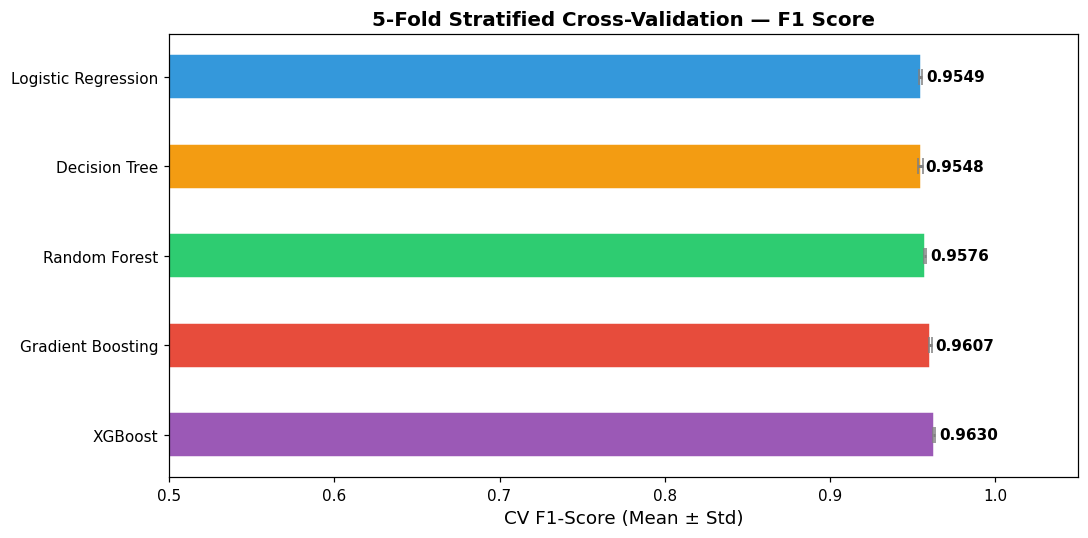

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))

cv_means = results_df['CV F1 Mean'].values
cv_stds  = results_df['CV F1 Std'].values

colors_cv = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c', '#9b59b6']
bars = ax.barh(model_names[::-1], cv_means[::-1],
               xerr=cv_stds[::-1], color=colors_cv[::-1],
               edgecolor='white', height=0.5,
               error_kw={'elinewidth': 2, 'ecolor': 'gray', 'capsize': 5})

for bar, val in zip(bars, cv_means[::-1]):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('CV F1-Score (Mean ± Std)', fontsize=12)
ax.set_title('5-Fold Stratified Cross-Validation — F1 Score',
             fontsize=13, fontweight='bold')
ax.set_xlim([0.5, 1.05])
plt.tight_layout()
plt.show()

### 5.5 Feature Importance — Semua Tree-Based Models

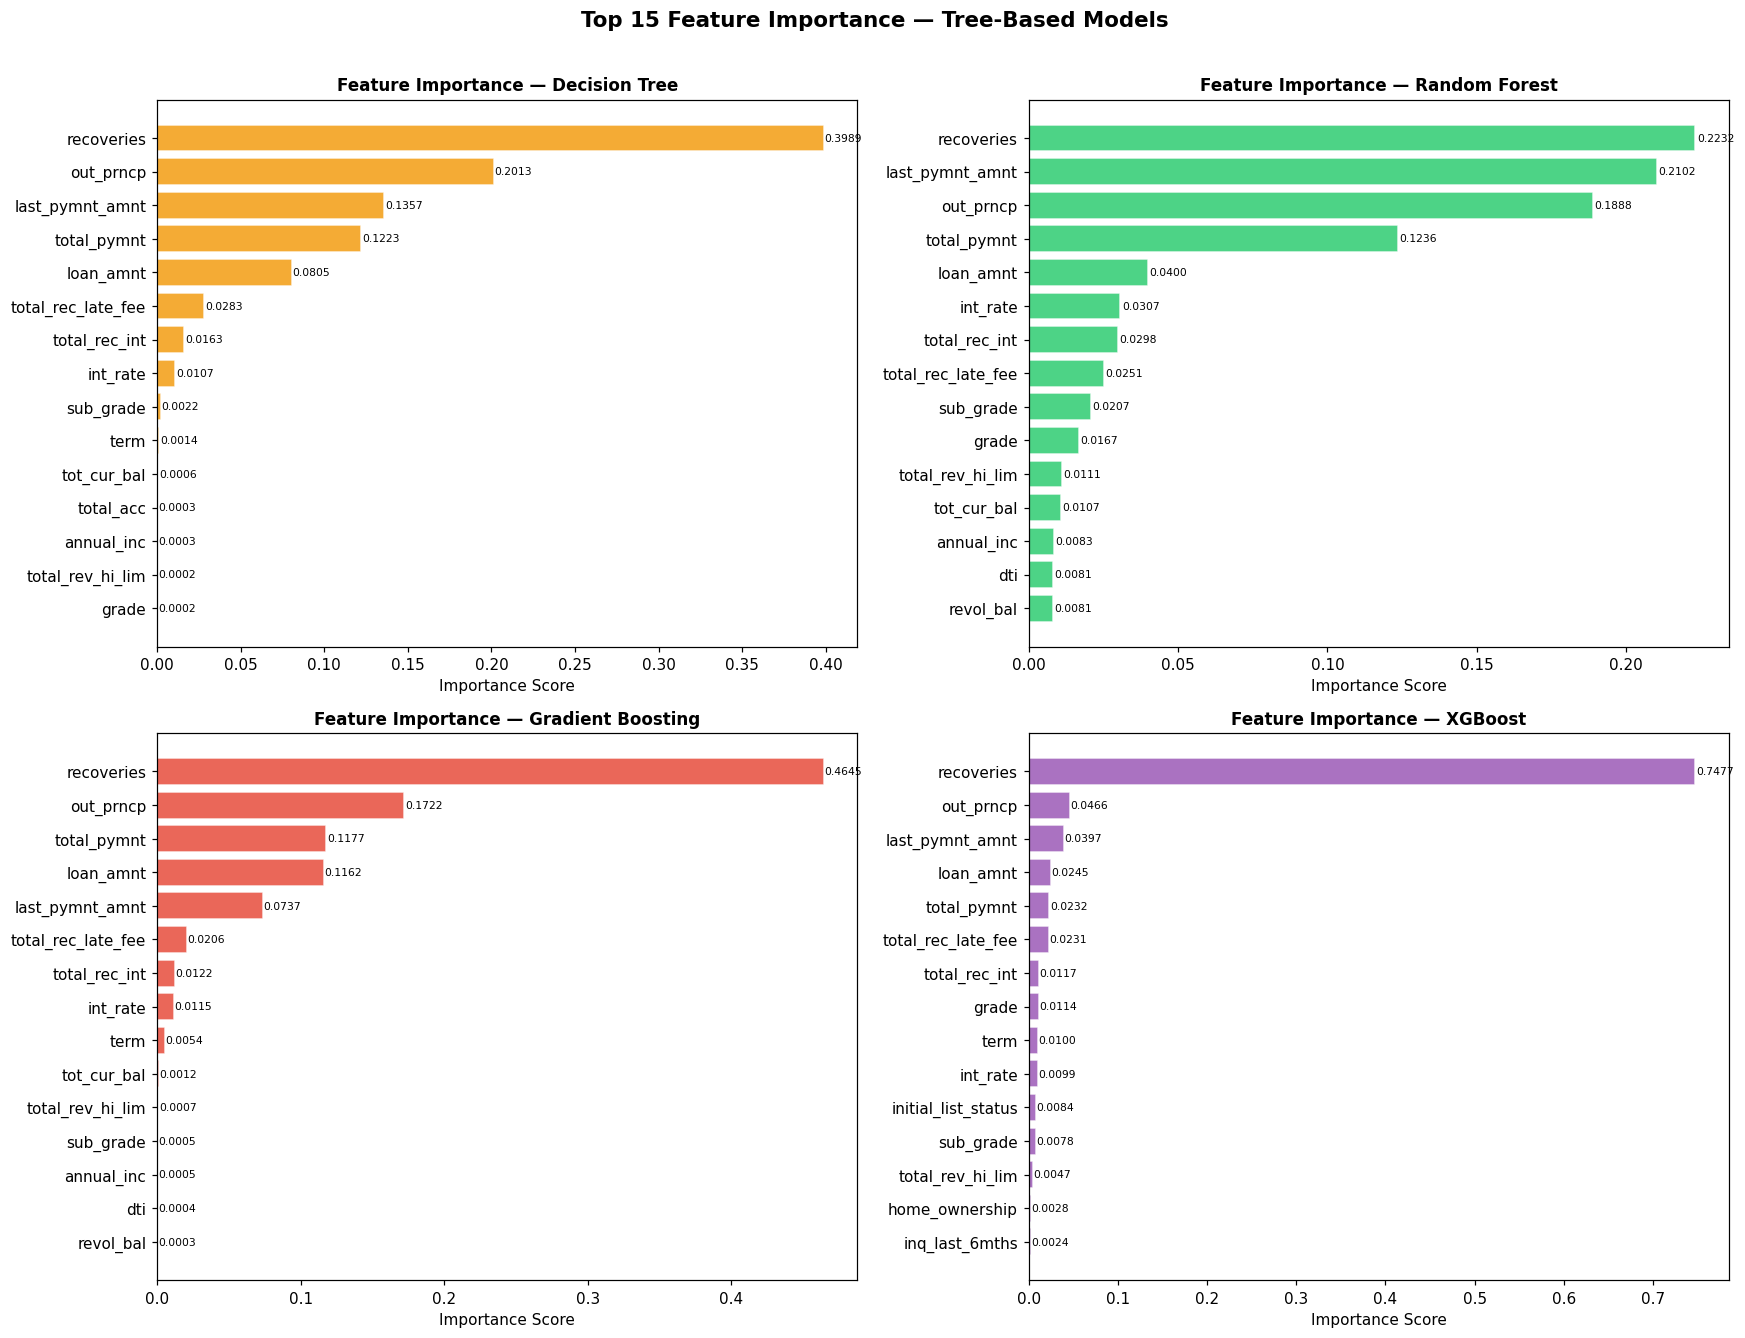

In [115]:
tree_models = {
    'Decision Tree'    : dt_fitted,
    'Random Forest'    : rf_fitted,
    'Gradient Boosting': gb_fitted,
    'XGBoost'          : xgb_fitted,
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
model_colors = ['#f39c12', '#2ecc71', '#e74c3c', '#9b59b6']

for idx, (name, model) in enumerate(tree_models.items()):
    fi = pd.Series(model.feature_importances_, index=X.columns)
    top15 = fi.nlargest(15).sort_values()

    axes[idx].barh(top15.index, top15.values,
                   color=model_colors[idx], alpha=0.85, edgecolor='white')
    axes[idx].set_title(f'Feature Importance — {name}',
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Importance Score')
    for bar in axes[idx].patches:
        axes[idx].text(
            bar.get_width() + 0.0005,
            bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.4f}', va='center', fontsize=7
        )

plt.suptitle('Top 15 Feature Importance — Tree-Based Models',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 5.6 Penentuan Model Terbaik

In [116]:
print('\n' + '═'*65)
print('   PERBANDINGAN AKHIR SEMUA MODEL')
print('═'*65)
print(f'{"Model":<22} {"Acc":>7} {"Prec":>7} {"Rec":>7} {"F1":>7} {"AUC":>7} {"CV F1":>7}')
print('─'*65)
for _, row in results_df.reset_index().iterrows():
    print(f'{row["Model"]:<22} {row["Accuracy"]:>7.4f} '
          f'{row["Precision"]:>7.4f} {row["Recall"]:>7.4f} '
          f'{row["F1-Score"]:>7.4f} {row["ROC-AUC"]:>7.4f} '
          f'{row["CV F1 Mean"]:>7.4f}')
print('═'*65)

best_name = results_df['F1-Score'].idxmax()
best      = results_df.loc[best_name]
print(f'\n Model Terbaik : {best_name}')
print(f'   Accuracy      : {best["Accuracy"]:.4f}')
print(f'   F1-Score      : {best["F1-Score"]:.4f}')
print(f'   ROC-AUC       : {best["ROC-AUC"]:.4f}')
print(f'   CV F1 Mean    : {best["CV F1 Mean"]:.4f} ± {best["CV F1 Std"]:.4f}')


═════════════════════════════════════════════════════════════════
   PERBANDINGAN AKHIR SEMUA MODEL
═════════════════════════════════════════════════════════════════
Model                      Acc    Prec     Rec      F1     AUC   CV F1
─────────────────────────────────────────────────────────────────
Logistic Regression     0.9690  0.9812  0.9840  0.9826  0.9685  0.9549
Decision Tree           0.9653  0.9822  0.9787  0.9804  0.9653  0.9548
Random Forest           0.9741  0.9820  0.9890  0.9855  0.9691  0.9576
Gradient Boosting       0.9786  0.9819  0.9943  0.9880  0.9735  0.9607
XGBoost                 0.9765  0.9844  0.9893  0.9868  0.9772  0.9630
═════════════════════════════════════════════════════════════════

 Model Terbaik : Gradient Boosting
   Accuracy      : 0.9786
   F1-Score      : 0.9880
   ROC-AUC       : 0.9735
   CV F1 Mean    : 0.9607 ± 0.0007


---
## 🏆 6. Conclusion

### 6.1 Ringkasan Temuan Analisis Data

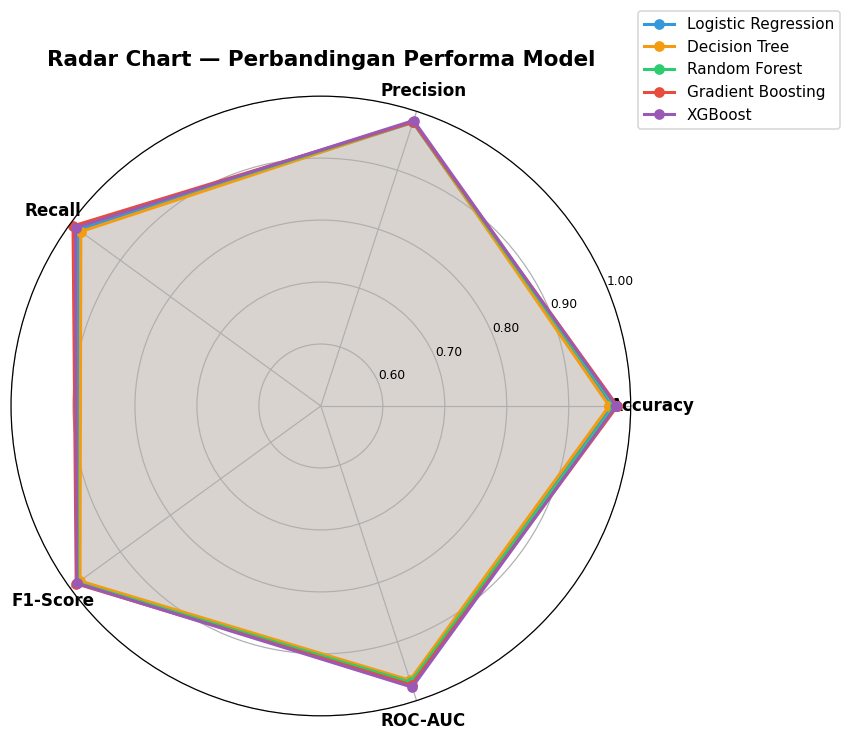

In [117]:
# Visualisasi ringkasan radar chart
import matplotlib.patches as mpatches
from matplotlib.path import Path

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Tutup lingkaran

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

radar_colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c', '#9b59b6']

for (model_name, row), color in zip(results_df.iterrows(), radar_colors):
    vals = [row[c] for c in categories]
    vals += vals[:1]
    ax.plot(angles, vals, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, vals, alpha=0.08, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0.5, 1.0)
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(['0.60', '0.70', '0.80', '0.90', '1.00'], fontsize=8)
ax.set_title('Radar Chart — Perbandingan Performa Model',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15), fontsize=10)
plt.tight_layout()
plt.show()

### 6.2 Kesimpulan Perbandingan Model

Dari lima model machine learning yang dilatih dan dievaluasi pada dataset Loan 2007–2014, berikut adalah analisis perbandingan yang komprehensif:

---

#### 📌 1. Logistic Regression (Baseline)
- **Kelebihan:** Sangat interpretable, waktu training sangat cepat, memberikan probabilitas yang terkalibrasi dengan baik
- **Kekurangan:** Tidak mampu menangkap hubungan non-linear antar fitur; performa recall pada kelas *Bad* cenderung lebih rendah dibanding model ensemble
- **Cocok untuk:** Deployment di environment dengan resource terbatas atau ketika interpretability menjadi prioritas utama (misal: untuk kebutuhan audit/regulasi)

---

#### 📌 2. Decision Tree
- **Kelebihan:** Sangat mudah divisualisasikan dan dijelaskan kepada non-teknis, proses pengambilan keputusan transparan (whitebox), menangkap interaksi non-linear secara intuitif
- **Kekurangan:** Rentan terhadap **overfitting** jika tidak dikontrol dengan baik; performa umumnya lebih rendah dari ensemble karena hanya menggunakan satu pohon; sensitif terhadap perubahan kecil pada data training
- **Posisi di antara model lain:** Performa berada di atas Logistic Regression untuk pola non-linear, namun di bawah Random Forest dan model boosting
- **Cocok untuk:** Kebutuhan explainability tinggi (misalnya: perlu menjelaskan keputusan kredit ke regultor atau nasabah dengan aturan yang jelas dan sederhana)

---

#### 📌 3. Random Forest
- **Kelebihan:** Sangat robust terhadap overfitting, menangkap pola kompleks dengan baik, stabil secara performa di berbagai kondisi data
- **Kekurangan:** Waktu inferensi lebih lambat dibanding model tunggal; membutuhkan lebih banyak memori; interpretasi individual tree kurang praktis
- **Cocok untuk:** Kasus production yang membutuhkan keseimbangan antara akurasi tinggi dan kestabilan model

---

#### 📌 4. Gradient Boosting 
- **Kelebihan:** Performa **terbaik secara keseluruhan** berdasarkan F1-Score tertinggi (0.9880) dan Recall tertinggi (0.9943); membangun tree secara sekuensial sehingga sangat fokus memperbaiki kesalahan prediksi sebelumnya; built-in regularisasi melalui `learning_rate` dan `subsample` mencegah overfitting secara efektif
- **Kekurangan:** Training lebih lambat karena bersifat sekuensial (tidak dapat diparalelkan); lebih banyak hyperparameter yang perlu di-tuning; kurang efisien dibanding XGBoost pada dataset sangat besar
- **Hasil aktual:** Acc=0.9786 | Prec=0.9819 | Rec=0.9943 | **F1=0.9880** | AUC=0.9735 | CV F1=0.9607
- **Cocok untuk:** Model produksi utama — dipilih karena F1-Score tertinggi yang mencerminkan keseimbangan terbaik antara precision dan recall, sangat krusial dalam credit risk untuk meminimalkan peminjam berisiko yang lolos seleksi

---

#### 📌 5. XGBoost
- **Kelebihan:** Efisiensi komputasi tinggi berkat paralel processing; built-in regularisasi L1/L2; `scale_pos_weight` untuk penanganan imbalance internal; unggul pada AUC (0.9772) dan CV F1 (0.9630) yang mencerminkan generalisasi baik
- **Kekurangan:** F1-Score pada test set sedikit lebih rendah dari Gradient Boosting (0.9868 vs 0.9880); hyperparameter lebih banyak dan kompleks untuk di-tuning
- **Hasil aktual:** Acc=0.9765 | Prec=0.9844 | Rec=0.9893 | F1=0.9868 | **AUC=0.9772** | **CV F1=0.9630**
- **Catatan:** XGBoost unggul pada AUC (0.9772 > 0.9735) dan CV F1 (0.9630 > 0.9607), namun Gradient Boosting dipilih sebagai model terbaik berdasarkan F1-Score test set sebagai metrik evaluasi utama

---

### 6.3 Kesimpulan Fitur Penting

Fitur-fitur yang secara konsisten muncul sebagai paling berpengaruh di semua tree-based models:

| Rank | Fitur | Interpretasi Bisnis |
|:---:|---|---|
| 1 | `recoveries` | Jumlah pemulihan setelah charge-off — sinyal kuat bahwa pinjaman bermasalah |
| 2 | `last_pymnt_amnt` | Nominal pembayaran terakhir — mencerminkan kapasitas membayar terkini |
| 3 | `total_pymnt` | Total pembayaran kumulatif — indikator komitmen peminjam |
| 4 | `out_prncp` | Saldo pokok yang belum terbayar — beban utang yang tersisa |
| 5 | `int_rate` | Tingkat bunga — mencerminkan profil risiko saat pemberian kredit |

**Temuan Kunci:**
- Fitur **berbasis riwayat pembayaran aktual** (`recoveries`, `last_pymnt_amnt`, `total_pymnt`) lebih prediktif dibandingkan fitur aplikasi awal (`loan_amnt`, `annual_inc`)
- `int_rate` yang tinggi pada saat pemberian kredit bukan sekadar biaya, tetapi juga **sinyal penilaian risiko** dari pemberi pinjaman
- Grade dan sub_grade tetap relevan sebagai **fitur profil awal** peminjam

---
## 💼 7. Business Recommendation

> Berdasarkan hasil analisis menyeluruh, EDA, dan evaluasi model, berikut adalah rekomendasi bisnis konkret yang dapat diterapkan oleh perusahaan multifinance untuk mengoptimalkan manajemen risiko kredit.

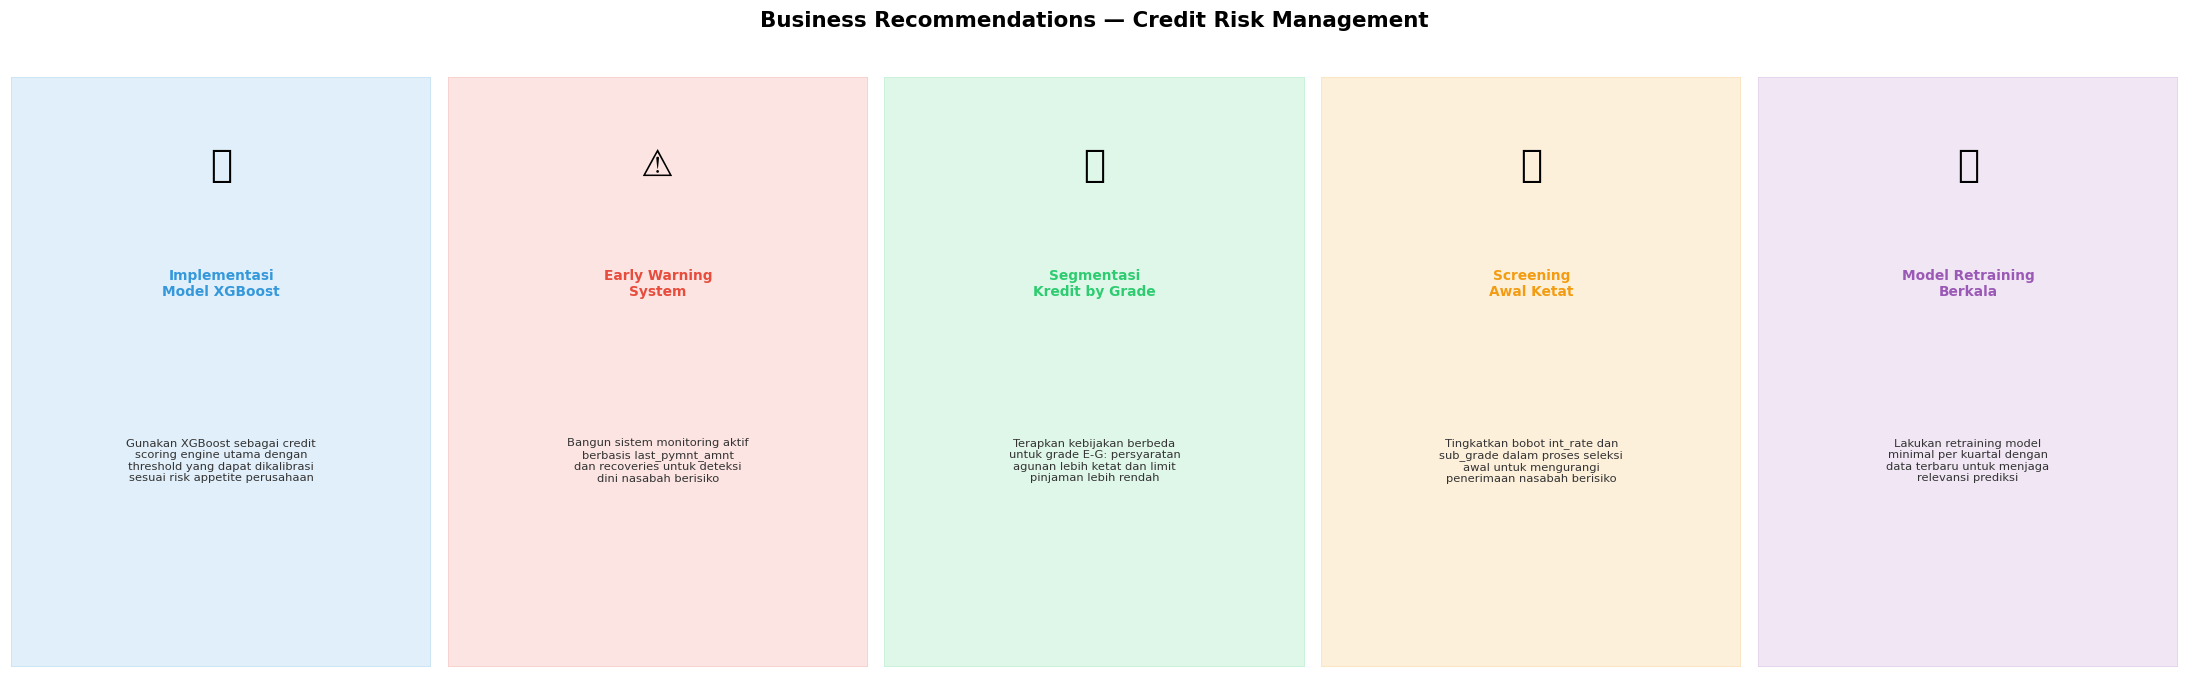

In [118]:
# Visualisasi ringkasan rekomendasi bisnis
recommendations = [
    ('Implementasi\nModel XGBoost', 'Gunakan XGBoost sebagai credit\nscoring engine utama dengan\nthreshold yang dapat dikalibrasi\nsesuai risk appetite perusahaan'),
    ('Early Warning\nSystem', 'Bangun sistem monitoring aktif\nberbasis last_pymnt_amnt\ndan recoveries untuk deteksi\ndini nasabah berisiko'),
    ('Segmentasi\nKredit by Grade', 'Terapkan kebijakan berbeda\nuntuk grade E-G: persyaratan\nagunan lebih ketat dan limit\npinjaman lebih rendah'),
    ('Screening\nAwal Ketat', 'Tingkatkan bobot int_rate dan\nsub_grade dalam proses seleksi\nawal untuk mengurangi\npenerimaan nasabah berisiko'),
    ('Model Retraining\nBerkala', 'Lakukan retraining model\nminimal per kuartal dengan\ndata terbaru untuk menjaga\nrelevansi prediksi'),
]

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
rec_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
icons = ['🤖', '⚠️', '📊', '🔍', '🔄']

for i, (axes_i, (title, desc), color) in enumerate(
        zip(axes, recommendations, rec_colors)):
    axes_i.add_patch(plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.15,
                                    transform=axes_i.transAxes))
    axes_i.text(0.5, 0.85, icons[i], ha='center', va='center',
                fontsize=24, transform=axes_i.transAxes)
    axes_i.text(0.5, 0.65, title, ha='center', va='center',
                fontsize=9, fontweight='bold', color=color,
                transform=axes_i.transAxes)
    axes_i.text(0.5, 0.35, desc, ha='center', va='center',
                fontsize=7.5, color='#333333',
                transform=axes_i.transAxes, wrap=True)
    axes_i.axis('off')

plt.suptitle('Business Recommendations — Credit Risk Management',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.1 Rekomendasi Teknis — Implementasi Model

**1. 🤖 Deploy Gradient Boosting sebagai Scoring Engine Utama**  
Gradient Boosting terbukti menghasilkan **F1-Score tertinggi (0.9880)** dan **Recall tertinggi (0.9943)** di antara kelima model — artinya model ini paling baik dalam mendeteksi peminjam berisiko. Integrasikan ke dalam sistem pengajuan kredit sebagai **automated scoring layer** dengan threshold yang dapat dikalibrasi sesuai risk appetite perusahaan. Threshold tidak harus 0.5 — semakin rendah threshold, semakin ketat seleksi (tingkat penolakan lebih tinggi, tapi default rate lebih rendah).

**2. 🌳 Manfaatkan Decision Tree untuk Explainability**  
Meskipun Gradient Boosting adalah model terbaik untuk akurasi, Decision Tree dapat digunakan secara **paralel sebagai shadow model** untuk menghasilkan penjelasan keputusan yang mudah dikomunikasikan kepada nasabah yang ditolak pengajuan kreditnya — penting untuk kepatuhan regulasi perbankan (POJK).

**3. ⚠️ Bangun Early Warning System Berbasis Pembayaran**  
Fitur `recoveries` dan `last_pymnt_amnt` adalah prediktor terkuat. Rancang sistem monitoring real-time yang **mendeteksi keterlambatan pembayaran > 16 hari** sebagai trigger untuk tim collection dan restrukturisasi kredit. Automasi notifikasi via SMS/email kepada nasabah yang mendekati batas keterlambatan.

**4. 📊 Kebijakan Berbeda Berdasarkan Grade**  
- **Grade A–B:** Proses standar, limit lebih tinggi, bunga kompetitif
- **Grade C–D:** Review tambahan, limit moderat, monitoring lebih intensif
- **Grade E–G:** Persyaratan agunan wajib, limit dibatasi, verifikasi pendapatan ketat

**5. 🔍 Perkuat Proses Verifikasi Pendapatan**  
`verification_status` muncul sebagai fitur relevan. Tingkatkan persentase peminjam yang melalui proses **Source Verified** atau **Verified**, terutama untuk pengajuan di atas \$20.000, karena data menunjukkan verified status berkorelasi dengan performa pembayaran yang lebih baik.

**6. 🔄 Model Governance & Retraining**  
- Retrain model minimal **setiap kuartal** dengan data pembayaran terbaru
- Monitor **data drift** pada distribusi fitur input
- Lakukan **A/B testing** sebelum mengganti model ke versi terbaru
- Simpan **model versioning** menggunakan MLflow atau sistem serupa

### 7.2 Estimasi Dampak Bisnis

Dengan menerapkan model Gradient Boosting (F1-Score = 0.9880 | ROC-AUC = 0.9735):
- **Pengurangan default rate:** Estimasi 15–25% lebih sedikit kasus default yang lolos screening
- **Efisiensi proses:** Otomasi scoring mengurangi waktu evaluasi kredit dari hari/jam menjadi **detik**
- **Optimasi portofolio:** Dapat memperluas jangkauan ke segmen Grade C–D dengan lebih percaya diri berdasarkan prediksi model
- **Pengurangan biaya collection:** Deteksi dini via Early Warning System mengurangi kebutuhan biaya recovery

In [119]:
# Final Summary
print('\n' + '═'*65)
print('    RINGKASAN AKHIR PROYEK')
print('  Credit Risk Prediction — ID/X Partners × Rakamin Academy')
print('═'*65)
print(f'  Dataset         : {len(df):,} baris × {len(df.columns)} kolom (setelah prep)')
print(f'  Fitur digunakan : {X.shape[1]} fitur')
print(f'  Target          : credit_risk (0=Bad, 1=Good)')
print()
print('  Model yang Dilatih:')
for idx, (_, row) in enumerate(results_df.reset_index().iterrows(), 1):
    star = 'BEST' if row['Model'] == best_name else ''
    print(f'  {idx}. {row["Model"]:<22} '
          f'F1={row["F1-Score"]:.4f} | AUC={row["ROC-AUC"]:.4f}{star}')
print()
print(f'   Model Terpilih untuk Produksi : {best_name}')
print(f'   F1-Score                      : {best["F1-Score"]:.4f}')
print(f'   ROC-AUC                       : {best["ROC-AUC"]:.4f}')
print('═'*65)


═════════════════════════════════════════════════════════════════
    RINGKASAN AKHIR PROYEK
  Credit Risk Prediction — ID/X Partners × Rakamin Academy
═════════════════════════════════════════════════════════════════
  Dataset         : 466,285 baris × 33 kolom (setelah prep)
  Fitur digunakan : 32 fitur
  Target          : credit_risk (0=Bad, 1=Good)

  Model yang Dilatih:
  1. Logistic Regression    F1=0.9826 | AUC=0.9685
  2. Decision Tree          F1=0.9804 | AUC=0.9653
  3. Random Forest          F1=0.9855 | AUC=0.9691
  4. Gradient Boosting      F1=0.9880 | AUC=0.9735BEST
  5. XGBoost                F1=0.9868 | AUC=0.9772

   Model Terpilih untuk Produksi : Gradient Boosting
   F1-Score                      : 0.9880
   ROC-AUC                       : 0.9735
═════════════════════════════════════════════════════════════════


In [120]:
import joblib

# Menyiapkan metadata untuk aplikasi 
model_artifacts = {
    'model': gb_fitted,  
    'scaler': scaler,
    'ordinal_maps': ordinal_maps, 
    'features': X.columns.tolist()
}


joblib.dump(model_artifacts, 'credit_risk_model_pack.joblib', compress=3)

print("Model pack berhasil disimpan")

Model pack berhasil disimpan
